In [1]:
import gc
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import time

import category_encoders as ce
import lightgbm as lgb
from sklearn import metrics

import sys
sys.path.append("../utils")
from metrics import compute_recall_at4, compute_normalized_gini, compute_amex_metric
#from messaging import send_message

pd.set_option('display.max_columns', None)

In [2]:
# metrics in lgbm format

def metric_recall_at4(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'recall_at4', compute_recall_at4(y_true, y_pred), True

def metric_normalized_gini(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'norm_gini', compute_normalized_gini(y_true, y_pred), True

def metric_amex(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'amex_metric', compute_amex_metric(y_true, y_pred), True

In [3]:
# CONFIG PARAMS
N_REPEATS = 3
DATASET_VERSION = "04"

In [4]:
OOF_PATH = Path(f"../data/oof/lgbm-gbrt-bce-dsv{DATASET_VERSION}")
SUB_PATH = Path(f"../data/subs/lgbm-gbrt-bce-dsv{DATASET_VERSION}")
ART_PATH = Path(f"../artifacts/lgbm-gbrt-bce-dsv{DATASET_VERSION}")

if not OOF_PATH.exists():
    OOF_PATH.mkdir(parents=True, exist_ok=True)
if not SUB_PATH.exists():
    SUB_PATH.mkdir(parents=True, exist_ok=True)
if not ART_PATH.exists():
    ART_PATH.mkdir(parents=True, exist_ok=True)

***
## load and prepare data

In [5]:
train = pd.read_parquet(f"../data/processed/dsv{DATASET_VERSION}/train.parquet")
train_labels = pd.read_csv("../data/raw/train_labels.csv", index_col="customer_ID")

In [6]:
input_feats = train.columns.tolist()
#categ_feats = [
#    'B_30_first', 'B_38_first', 'D_114_first', 'D_116_first', 'D_117_first', 
#    'D_120_first', 'D_126_first', 'D_63_first', 'D_64_first', 'D_66_first', 'D_68_first',
#    'B_30_last', 'B_38_last', 'D_114_last', 'D_116_last', 'D_117_last', 
#    'D_120_last', 'D_126_last', 'D_63_last', 'D_64_last', 'D_66_last', 'D_68_last',
#]
len(input_feats)

1639

In [7]:
train = pd.merge(train, train_labels, how="inner", left_index=True, right_index=True)
del train_labels
gc.collect()

102

***
## model training

train with repeated cross validation

In [8]:
model_params = {
    'boosting':'gbdt',
    'objective': 'binary',
    'metric': 'None',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'max_bin': 511,
    'bin_construct_sample_cnt': 100000000,
    'bagging_freq': 1,
    'bagging_fraction': 0.95,
    'feature_fraction': 0.15,
    'lambda_l1': 10.352308845012756,
    'lambda_l2': 1.569788743184169,
    'min_data_in_leaf': 2000,
    'path_smooth': 30.4965047619009,
    'seed': 2112,
    'force_col_wise': True,
    'feature_pre_filter': False,
    'verbosity': -1,
}

In [9]:
def train_models(dataframe: pd.DataFrame, n_folds: int = 5,) -> tuple:
    
    models = list()
    
    # dataframe to store the oof predictions
    oof = dataframe[["target"]].copy()
    oof["pred"] = -1

    for fold in range(n_folds):
        
        print(f" training model {fold+1}/{n_folds} ".center(100, "#"))
        
        train_df = dataframe.query("fold != @fold").copy()
        valid_df = dataframe.query("fold == @fold").copy()
                
        train_dset = lgb.Dataset(
            data=train_df.loc[:,input_feats],
            label=train_df.loc[:,"target"].values,
            #categorical_feature=categ_feats,
            free_raw_data=True,
        )
        valid_dset = lgb.Dataset(
            data=valid_df.loc[:,input_feats],
            label=valid_df.loc[:,"target"].values,
            #categorical_feature=categ_feats,
            free_raw_data=True,
        )
        
        model = lgb.train(
            params=model_params,
            train_set=train_dset,
            valid_sets=[valid_dset,],
            feval=[metric_amex, metric_recall_at4, metric_normalized_gini],
            num_boost_round=3000,
            callbacks=[
                lgb.log_evaluation(period=50), 
                lgb.early_stopping(300, first_metric_only=True)
            ],
        )
        
        lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
        lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
        plt.show()        
        
        oof.loc[valid_df.index,"pred"] = model.predict(valid_df.loc[:,input_feats])
        
        models.append(model)
        del train_df,valid_df,train_dset,valid_dset
        gc.collect()
    
    return models,oof

In [10]:
# implement repeated cross validation
sorted(glob("../data/processed/cv*.csv"))

['../data/processed/cv0.csv',
 '../data/processed/cv1.csv',
 '../data/processed/cv2.csv',
 '../data/processed/cv3.csv',
 '../data/processed/cv4.csv',
 '../data/processed/cv5.csv',
 '../data/processed/cv6.csv',
 '../data/processed/cv7.csv',
 '../data/processed/cv8.csv',
 '../data/processed/cv9.csv']

############################### repeated cross-validation step: 1/3 ################################


######################################## training model 1/5 ########################################


Training until validation scores don't improve for 300 rounds


[50]	valid_0's amex_metric: 0.765494	valid_0's recall_at4: 0.622318	valid_0's norm_gini: 0.90867


[100]	valid_0's amex_metric: 0.77991	valid_0's recall_at4: 0.643945	valid_0's norm_gini: 0.915875


[150]	valid_0's amex_metric: 0.786201	valid_0's recall_at4: 0.652992	valid_0's norm_gini: 0.91941


[200]	valid_0's amex_metric: 0.789801	valid_0's recall_at4: 0.658251	valid_0's norm_gini: 0.921352


[250]	valid_0's amex_metric: 0.791254	valid_0's recall_at4: 0.660061	valid_0's norm_gini: 0.922448


[300]	valid_0's amex_metric: 0.794456	valid_0's recall_at4: 0.665741	valid_0's norm_gini: 0.923172


[350]	valid_0's amex_metric: 0.795428	valid_0's recall_at4: 0.667214	valid_0's norm_gini: 0.923642


[400]	valid_0's amex_metric: 0.796014	valid_0's recall_at4: 0.668013	valid_0's norm_gini: 0.924016


[450]	valid_0's amex_metric: 0.796495	valid_0's recall_at4: 0.668728	valid_0's norm_gini: 0.924262


[500]	valid_0's amex_metric: 0.796598	valid_0's recall_at4: 0.668728	valid_0's norm_gini: 0.924467


[550]	valid_0's amex_metric: 0.797007	valid_0's recall_at4: 0.669402	valid_0's norm_gini: 0.924613


[600]	valid_0's amex_metric: 0.797407	valid_0's recall_at4: 0.670033	valid_0's norm_gini: 0.924781


[650]	valid_0's amex_metric: 0.797539	valid_0's recall_at4: 0.670201	valid_0's norm_gini: 0.924876


[700]	valid_0's amex_metric: 0.797773	valid_0's recall_at4: 0.670538	valid_0's norm_gini: 0.925007


[750]	valid_0's amex_metric: 0.797295	valid_0's recall_at4: 0.669486	valid_0's norm_gini: 0.925104


[800]	valid_0's amex_metric: 0.797569	valid_0's recall_at4: 0.669991	valid_0's norm_gini: 0.925147


[850]	valid_0's amex_metric: 0.798063	valid_0's recall_at4: 0.670916	valid_0's norm_gini: 0.925209


[900]	valid_0's amex_metric: 0.797333	valid_0's recall_at4: 0.669444	valid_0's norm_gini: 0.925221


[950]	valid_0's amex_metric: 0.797412	valid_0's recall_at4: 0.66957	valid_0's norm_gini: 0.925254


[1000]	valid_0's amex_metric: 0.79751	valid_0's recall_at4: 0.669738	valid_0's norm_gini: 0.925283


[1050]	valid_0's amex_metric: 0.797434	valid_0's recall_at4: 0.669528	valid_0's norm_gini: 0.925341


[1100]	valid_0's amex_metric: 0.79742	valid_0's recall_at4: 0.669486	valid_0's norm_gini: 0.925355


Early stopping, best iteration is:
[835]	valid_0's amex_metric: 0.798323	valid_0's recall_at4: 0.671463	valid_0's norm_gini: 0.925183
Evaluated only: amex_metric


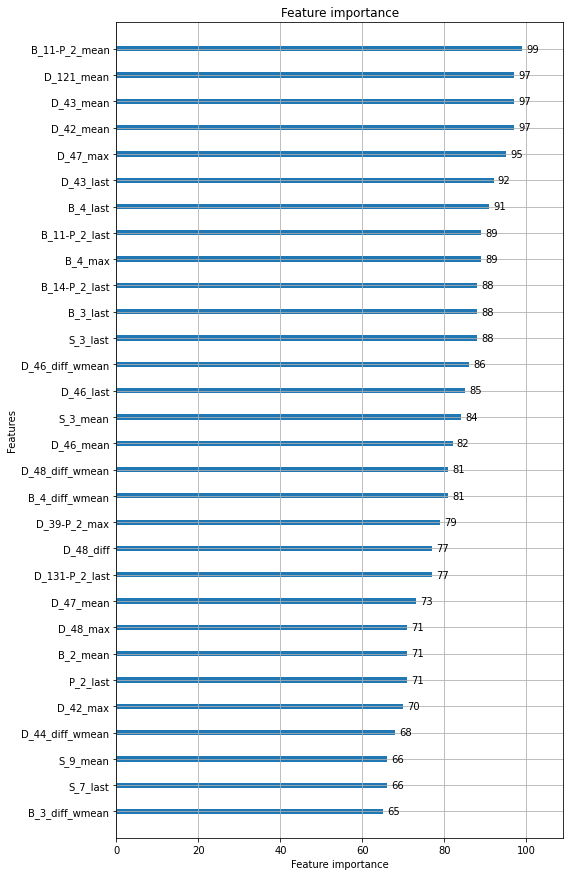

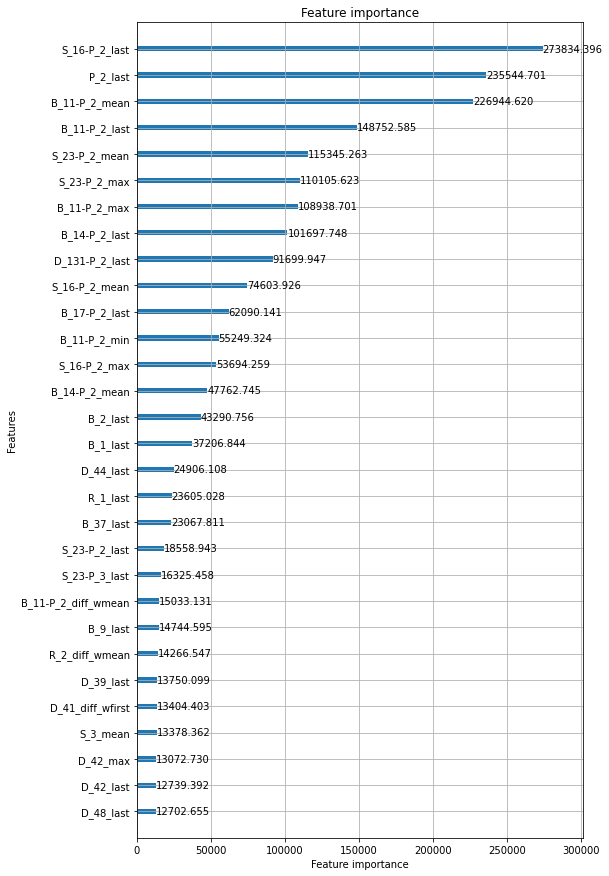

######################################## training model 2/5 ########################################


Training until validation scores don't improve for 300 rounds


[50]	valid_0's amex_metric: 0.763497	valid_0's recall_at4: 0.619625	valid_0's norm_gini: 0.907368


[100]	valid_0's amex_metric: 0.77574	valid_0's recall_at4: 0.63696	valid_0's norm_gini: 0.914519


[150]	valid_0's amex_metric: 0.783809	valid_0's recall_at4: 0.649331	valid_0's norm_gini: 0.918288


[200]	valid_0's amex_metric: 0.78734	valid_0's recall_at4: 0.654338	valid_0's norm_gini: 0.920342


[250]	valid_0's amex_metric: 0.791049	valid_0's recall_at4: 0.660565	valid_0's norm_gini: 0.921533


[300]	valid_0's amex_metric: 0.791874	valid_0's recall_at4: 0.661449	valid_0's norm_gini: 0.9223


[350]	valid_0's amex_metric: 0.792228	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.922838


[400]	valid_0's amex_metric: 0.79319	valid_0's recall_at4: 0.663174	valid_0's norm_gini: 0.923206


[450]	valid_0's amex_metric: 0.793464	valid_0's recall_at4: 0.663385	valid_0's norm_gini: 0.923544


[500]	valid_0's amex_metric: 0.793841	valid_0's recall_at4: 0.66389	valid_0's norm_gini: 0.923793


[550]	valid_0's amex_metric: 0.794127	valid_0's recall_at4: 0.664268	valid_0's norm_gini: 0.923986


[600]	valid_0's amex_metric: 0.794006	valid_0's recall_at4: 0.663848	valid_0's norm_gini: 0.924165


[650]	valid_0's amex_metric: 0.794148	valid_0's recall_at4: 0.663974	valid_0's norm_gini: 0.924321


[700]	valid_0's amex_metric: 0.794704	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.924424


[750]	valid_0's amex_metric: 0.795017	valid_0's recall_at4: 0.665531	valid_0's norm_gini: 0.924503


[800]	valid_0's amex_metric: 0.795188	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.924551


[850]	valid_0's amex_metric: 0.796161	valid_0's recall_at4: 0.667719	valid_0's norm_gini: 0.924604


[900]	valid_0's amex_metric: 0.795669	valid_0's recall_at4: 0.666667	valid_0's norm_gini: 0.924671


[950]	valid_0's amex_metric: 0.795797	valid_0's recall_at4: 0.666877	valid_0's norm_gini: 0.924717


[1000]	valid_0's amex_metric: 0.795712	valid_0's recall_at4: 0.666667	valid_0's norm_gini: 0.924758


[1050]	valid_0's amex_metric: 0.795356	valid_0's recall_at4: 0.665909	valid_0's norm_gini: 0.924802


[1100]	valid_0's amex_metric: 0.795854	valid_0's recall_at4: 0.666877	valid_0's norm_gini: 0.92483


[1150]	valid_0's amex_metric: 0.795757	valid_0's recall_at4: 0.666667	valid_0's norm_gini: 0.924847


Early stopping, best iteration is:
[857]	valid_0's amex_metric: 0.796211	valid_0's recall_at4: 0.667803	valid_0's norm_gini: 0.924619
Evaluated only: amex_metric


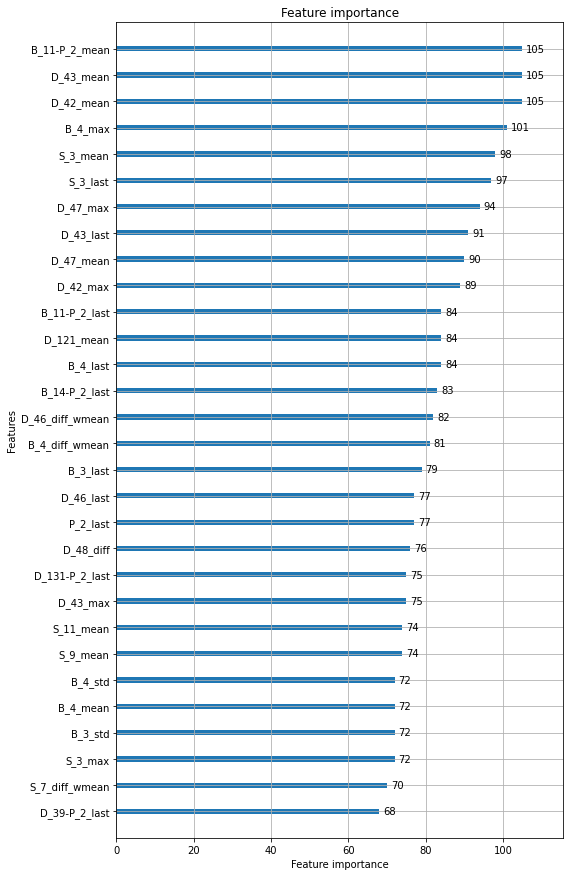

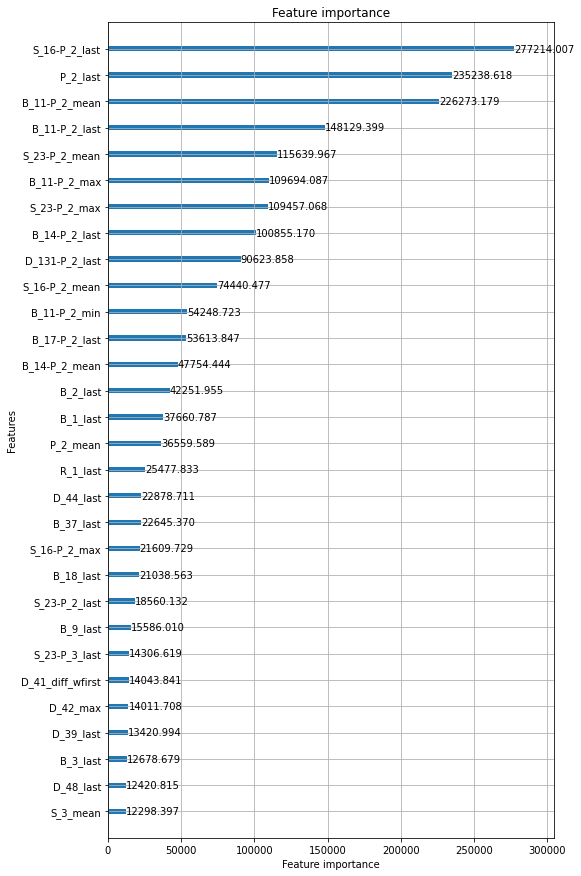

######################################## training model 3/5 ########################################


Training until validation scores don't improve for 300 rounds


[50]	valid_0's amex_metric: 0.759452	valid_0's recall_at4: 0.612219	valid_0's norm_gini: 0.906685


[100]	valid_0's amex_metric: 0.771926	valid_0's recall_at4: 0.630228	valid_0's norm_gini: 0.913625


[150]	valid_0's amex_metric: 0.778525	valid_0's recall_at4: 0.639906	valid_0's norm_gini: 0.917145


[200]	valid_0's amex_metric: 0.782315	valid_0's recall_at4: 0.645544	valid_0's norm_gini: 0.919085


[250]	valid_0's amex_metric: 0.784598	valid_0's recall_at4: 0.649036	valid_0's norm_gini: 0.92016


[300]	valid_0's amex_metric: 0.786579	valid_0's recall_at4: 0.652234	valid_0's norm_gini: 0.920924


[350]	valid_0's amex_metric: 0.787638	valid_0's recall_at4: 0.653833	valid_0's norm_gini: 0.921443


[400]	valid_0's amex_metric: 0.787339	valid_0's recall_at4: 0.652865	valid_0's norm_gini: 0.921812


[450]	valid_0's amex_metric: 0.787262	valid_0's recall_at4: 0.652445	valid_0's norm_gini: 0.922079


[500]	valid_0's amex_metric: 0.787737	valid_0's recall_at4: 0.65316	valid_0's norm_gini: 0.922314


[550]	valid_0's amex_metric: 0.78869	valid_0's recall_at4: 0.654885	valid_0's norm_gini: 0.922495


[600]	valid_0's amex_metric: 0.789596	valid_0's recall_at4: 0.656526	valid_0's norm_gini: 0.922667


[650]	valid_0's amex_metric: 0.788817	valid_0's recall_at4: 0.654843	valid_0's norm_gini: 0.92279


[700]	valid_0's amex_metric: 0.789241	valid_0's recall_at4: 0.6556	valid_0's norm_gini: 0.922882


[750]	valid_0's amex_metric: 0.788922	valid_0's recall_at4: 0.654885	valid_0's norm_gini: 0.922959


[800]	valid_0's amex_metric: 0.788868	valid_0's recall_at4: 0.654717	valid_0's norm_gini: 0.92302


[850]	valid_0's amex_metric: 0.789389	valid_0's recall_at4: 0.655685	valid_0's norm_gini: 0.923092


[900]	valid_0's amex_metric: 0.789528	valid_0's recall_at4: 0.655937	valid_0's norm_gini: 0.923119


Early stopping, best iteration is:
[609]	valid_0's amex_metric: 0.789795	valid_0's recall_at4: 0.656905	valid_0's norm_gini: 0.922684
Evaluated only: amex_metric


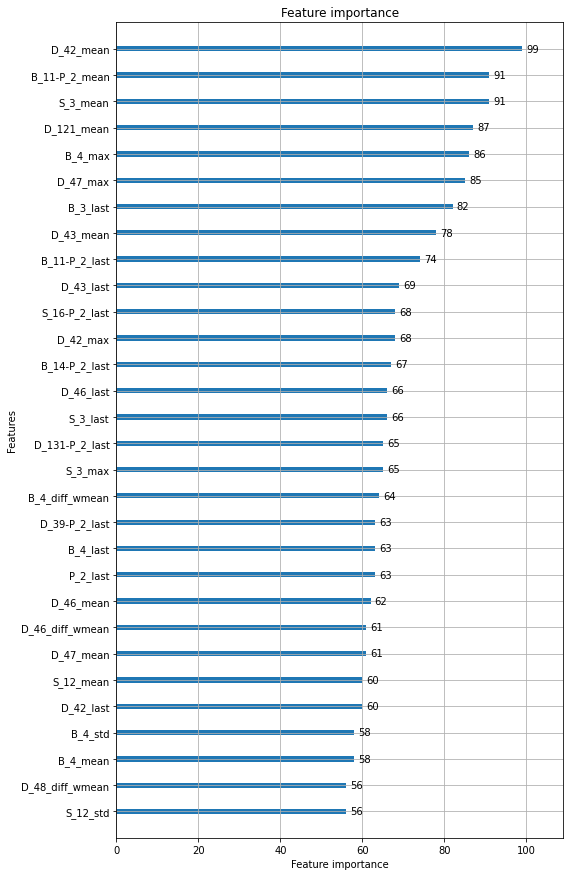

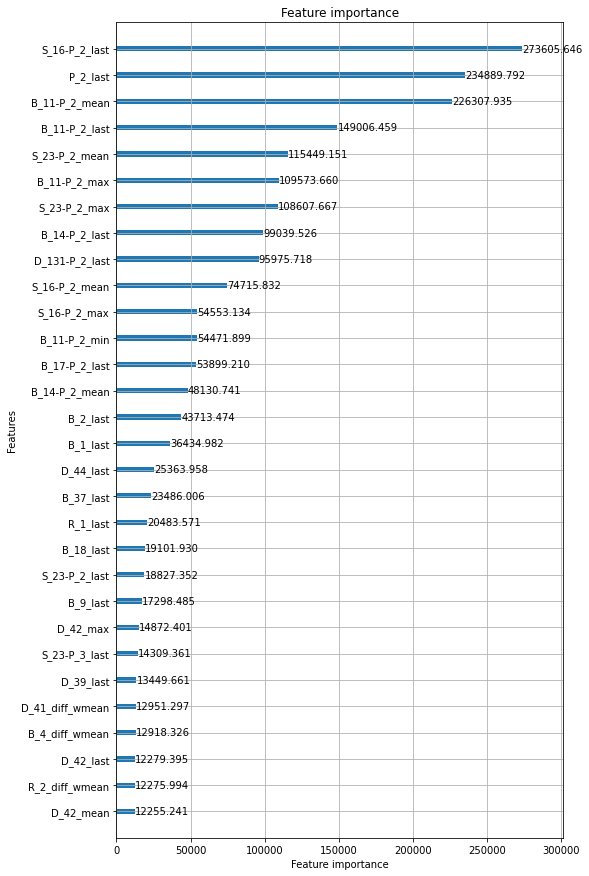

######################################## training model 4/5 ########################################


Training until validation scores don't improve for 300 rounds


[50]	valid_0's amex_metric: 0.760142	valid_0's recall_at4: 0.61397	valid_0's norm_gini: 0.906314


[100]	valid_0's amex_metric: 0.773085	valid_0's recall_at4: 0.632695	valid_0's norm_gini: 0.913476


[150]	valid_0's amex_metric: 0.778668	valid_0's recall_at4: 0.640059	valid_0's norm_gini: 0.917276


[200]	valid_0's amex_metric: 0.782543	valid_0's recall_at4: 0.645782	valid_0's norm_gini: 0.919304


[250]	valid_0's amex_metric: 0.783928	valid_0's recall_at4: 0.647296	valid_0's norm_gini: 0.92056


[300]	valid_0's amex_metric: 0.785562	valid_0's recall_at4: 0.649695	valid_0's norm_gini: 0.921429


[350]	valid_0's amex_metric: 0.786493	valid_0's recall_at4: 0.650957	valid_0's norm_gini: 0.922028


[400]	valid_0's amex_metric: 0.787505	valid_0's recall_at4: 0.652556	valid_0's norm_gini: 0.922455


[450]	valid_0's amex_metric: 0.78799	valid_0's recall_at4: 0.65323	valid_0's norm_gini: 0.922751


[500]	valid_0's amex_metric: 0.788624	valid_0's recall_at4: 0.654197	valid_0's norm_gini: 0.92305


[550]	valid_0's amex_metric: 0.788916	valid_0's recall_at4: 0.654576	valid_0's norm_gini: 0.923256


[600]	valid_0's amex_metric: 0.789345	valid_0's recall_at4: 0.655291	valid_0's norm_gini: 0.923398


[650]	valid_0's amex_metric: 0.78946	valid_0's recall_at4: 0.655376	valid_0's norm_gini: 0.923544


[700]	valid_0's amex_metric: 0.788834	valid_0's recall_at4: 0.653987	valid_0's norm_gini: 0.923681


[750]	valid_0's amex_metric: 0.789502	valid_0's recall_at4: 0.655207	valid_0's norm_gini: 0.923796


[800]	valid_0's amex_metric: 0.789756	valid_0's recall_at4: 0.655628	valid_0's norm_gini: 0.923884


[850]	valid_0's amex_metric: 0.790058	valid_0's recall_at4: 0.656175	valid_0's norm_gini: 0.923942


[900]	valid_0's amex_metric: 0.790061	valid_0's recall_at4: 0.656091	valid_0's norm_gini: 0.924031


[950]	valid_0's amex_metric: 0.789761	valid_0's recall_at4: 0.65546	valid_0's norm_gini: 0.924063


[1000]	valid_0's amex_metric: 0.789634	valid_0's recall_at4: 0.655165	valid_0's norm_gini: 0.924104


[1050]	valid_0's amex_metric: 0.789814	valid_0's recall_at4: 0.65546	valid_0's norm_gini: 0.924169


[1100]	valid_0's amex_metric: 0.789692	valid_0's recall_at4: 0.655207	valid_0's norm_gini: 0.924177


Early stopping, best iteration is:
[828]	valid_0's amex_metric: 0.790572	valid_0's recall_at4: 0.657227	valid_0's norm_gini: 0.923917
Evaluated only: amex_metric


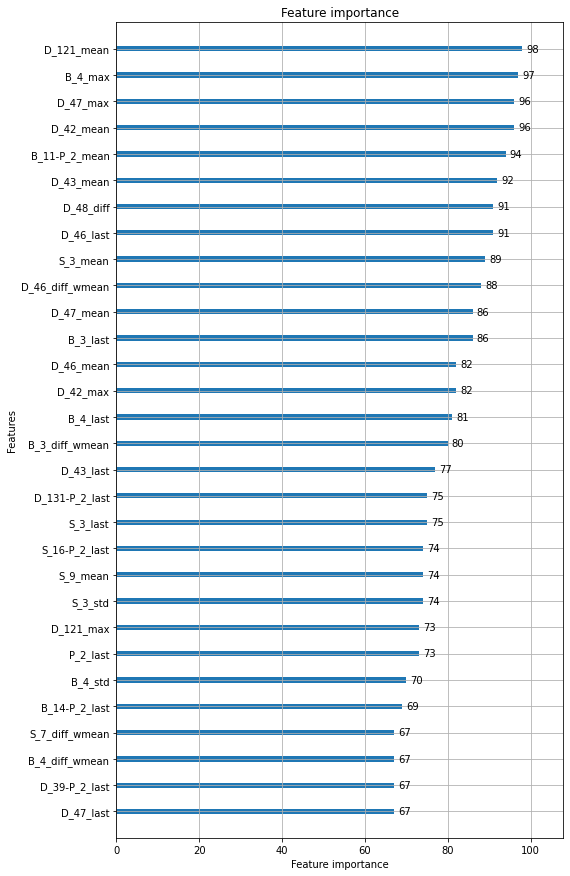

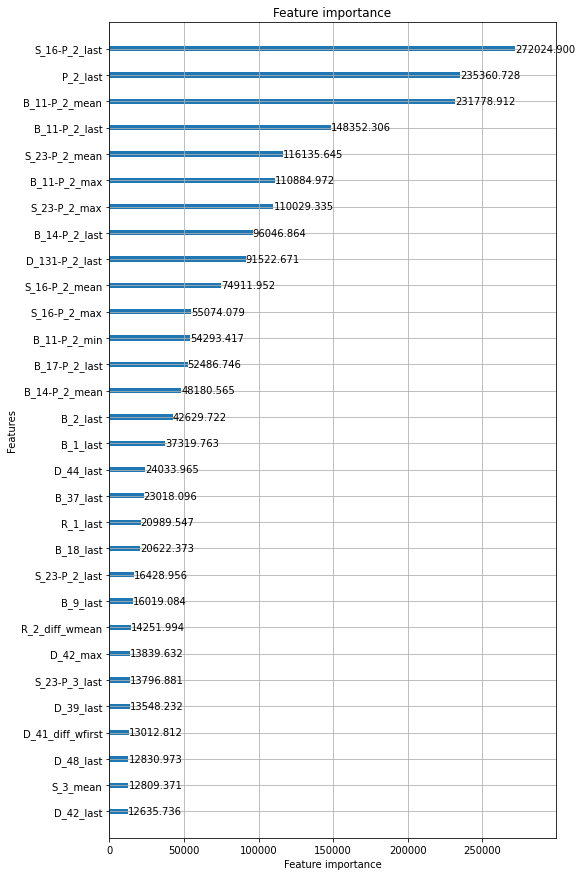

######################################## training model 5/5 ########################################


Training until validation scores don't improve for 300 rounds


[50]	valid_0's amex_metric: 0.767468	valid_0's recall_at4: 0.625163	valid_0's norm_gini: 0.909773


[100]	valid_0's amex_metric: 0.780988	valid_0's recall_at4: 0.644982	valid_0's norm_gini: 0.916995


[150]	valid_0's amex_metric: 0.787936	valid_0's recall_at4: 0.655333	valid_0's norm_gini: 0.920538


[200]	valid_0's amex_metric: 0.791961	valid_0's recall_at4: 0.661477	valid_0's norm_gini: 0.922445


[250]	valid_0's amex_metric: 0.794067	valid_0's recall_at4: 0.664591	valid_0's norm_gini: 0.923542


[300]	valid_0's amex_metric: 0.79551	valid_0's recall_at4: 0.666779	valid_0's norm_gini: 0.924242


[350]	valid_0's amex_metric: 0.795886	valid_0's recall_at4: 0.666989	valid_0's norm_gini: 0.924782


[400]	valid_0's amex_metric: 0.796765	valid_0's recall_at4: 0.668378	valid_0's norm_gini: 0.925152


[450]	valid_0's amex_metric: 0.79716	valid_0's recall_at4: 0.668883	valid_0's norm_gini: 0.925437


[500]	valid_0's amex_metric: 0.798032	valid_0's recall_at4: 0.670398	valid_0's norm_gini: 0.925666


[550]	valid_0's amex_metric: 0.79803	valid_0's recall_at4: 0.670229	valid_0's norm_gini: 0.925831


[600]	valid_0's amex_metric: 0.798446	valid_0's recall_at4: 0.670903	valid_0's norm_gini: 0.92599


[650]	valid_0's amex_metric: 0.798544	valid_0's recall_at4: 0.670987	valid_0's norm_gini: 0.926101


[700]	valid_0's amex_metric: 0.798571	valid_0's recall_at4: 0.670903	valid_0's norm_gini: 0.92624


[750]	valid_0's amex_metric: 0.798409	valid_0's recall_at4: 0.670482	valid_0's norm_gini: 0.926335


[800]	valid_0's amex_metric: 0.798418	valid_0's recall_at4: 0.670398	valid_0's norm_gini: 0.926438


[850]	valid_0's amex_metric: 0.799146	valid_0's recall_at4: 0.671786	valid_0's norm_gini: 0.926506


[900]	valid_0's amex_metric: 0.799876	valid_0's recall_at4: 0.673217	valid_0's norm_gini: 0.926534


[950]	valid_0's amex_metric: 0.800435	valid_0's recall_at4: 0.674269	valid_0's norm_gini: 0.9266


[1000]	valid_0's amex_metric: 0.799764	valid_0's recall_at4: 0.67288	valid_0's norm_gini: 0.926649


[1050]	valid_0's amex_metric: 0.800381	valid_0's recall_at4: 0.674101	valid_0's norm_gini: 0.926661


[1100]	valid_0's amex_metric: 0.800369	valid_0's recall_at4: 0.674058	valid_0's norm_gini: 0.926679


[1150]	valid_0's amex_metric: 0.799512	valid_0's recall_at4: 0.672333	valid_0's norm_gini: 0.92669


[1200]	valid_0's amex_metric: 0.800162	valid_0's recall_at4: 0.673638	valid_0's norm_gini: 0.926686


[1250]	valid_0's amex_metric: 0.79936	valid_0's recall_at4: 0.671997	valid_0's norm_gini: 0.926723


[1300]	valid_0's amex_metric: 0.799815	valid_0's recall_at4: 0.67288	valid_0's norm_gini: 0.926749


[1350]	valid_0's amex_metric: 0.800263	valid_0's recall_at4: 0.673764	valid_0's norm_gini: 0.926761


Early stopping, best iteration is:
[1053]	valid_0's amex_metric: 0.800571	valid_0's recall_at4: 0.674479	valid_0's norm_gini: 0.926662
Evaluated only: amex_metric


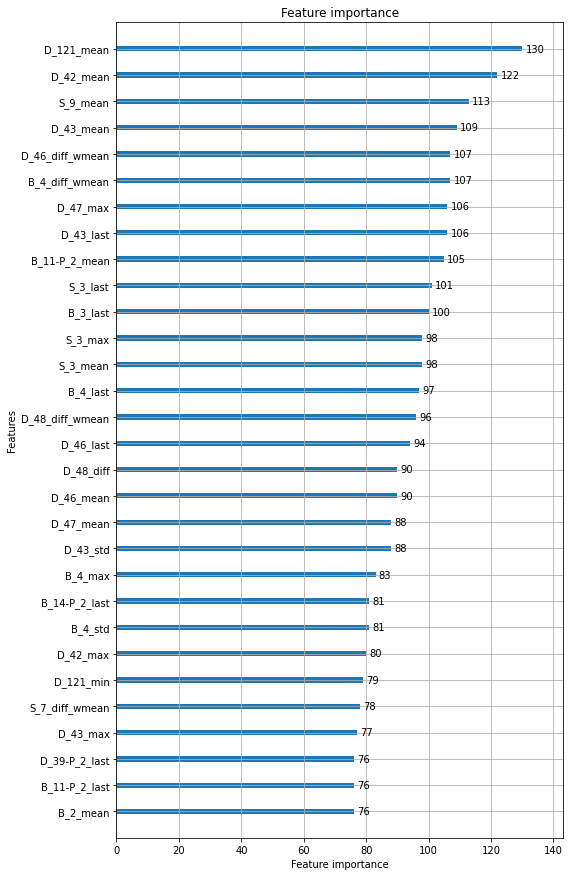

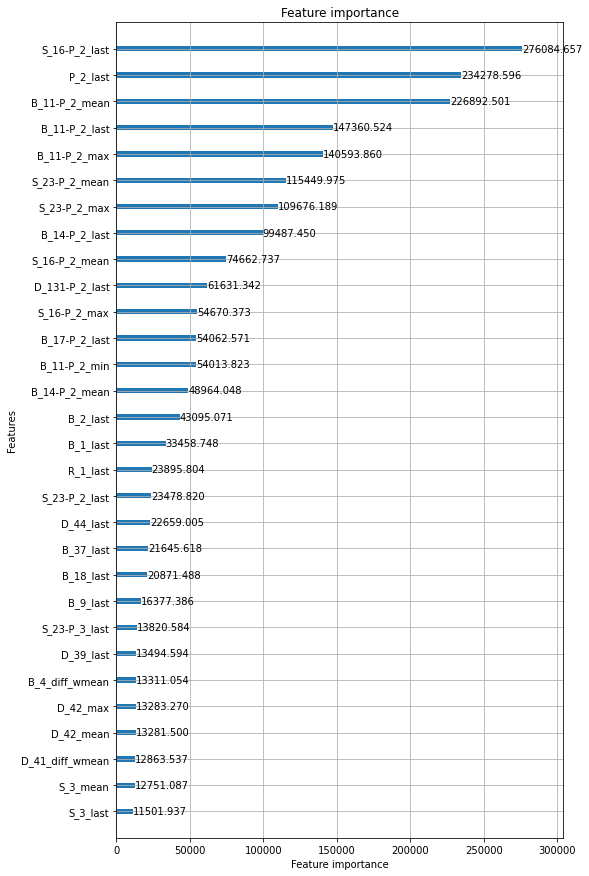

Training time: 14.237477600574493 min.


OOF recall_at4: 0.6648180563503552


OOF normalized_gini: 0.924489318296


OOF competition metric: 0.7946536873231775


############################### repeated cross-validation step: 2/3 ################################


######################################## training model 1/5 ########################################


Training until validation scores don't improve for 300 rounds


[50]	valid_0's amex_metric: 0.76574	valid_0's recall_at4: 0.623033	valid_0's norm_gini: 0.908446


[100]	valid_0's amex_metric: 0.778052	valid_0's recall_at4: 0.640579	valid_0's norm_gini: 0.915525


[150]	valid_0's amex_metric: 0.786136	valid_0's recall_at4: 0.653076	valid_0's norm_gini: 0.919197


[200]	valid_0's amex_metric: 0.789874	valid_0's recall_at4: 0.658546	valid_0's norm_gini: 0.921203


[250]	valid_0's amex_metric: 0.791949	valid_0's recall_at4: 0.661575	valid_0's norm_gini: 0.922323


[300]	valid_0's amex_metric: 0.79255	valid_0's recall_at4: 0.661996	valid_0's norm_gini: 0.923103


[350]	valid_0's amex_metric: 0.793426	valid_0's recall_at4: 0.663216	valid_0's norm_gini: 0.923636


[400]	valid_0's amex_metric: 0.794492	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.924001


[450]	valid_0's amex_metric: 0.794522	valid_0's recall_at4: 0.664773	valid_0's norm_gini: 0.92427


[500]	valid_0's amex_metric: 0.794747	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.92451


[550]	valid_0's amex_metric: 0.795129	valid_0's recall_at4: 0.665573	valid_0's norm_gini: 0.924685


[600]	valid_0's amex_metric: 0.795361	valid_0's recall_at4: 0.665951	valid_0's norm_gini: 0.924771


[650]	valid_0's amex_metric: 0.79544	valid_0's recall_at4: 0.665993	valid_0's norm_gini: 0.924887


[700]	valid_0's amex_metric: 0.795405	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.924984


[750]	valid_0's amex_metric: 0.795556	valid_0's recall_at4: 0.666036	valid_0's norm_gini: 0.925077


[800]	valid_0's amex_metric: 0.795734	valid_0's recall_at4: 0.666288	valid_0's norm_gini: 0.925181


[850]	valid_0's amex_metric: 0.796173	valid_0's recall_at4: 0.667087	valid_0's norm_gini: 0.925258


[900]	valid_0's amex_metric: 0.796503	valid_0's recall_at4: 0.667719	valid_0's norm_gini: 0.925287


[950]	valid_0's amex_metric: 0.796295	valid_0's recall_at4: 0.667256	valid_0's norm_gini: 0.925335


[1000]	valid_0's amex_metric: 0.795965	valid_0's recall_at4: 0.66654	valid_0's norm_gini: 0.92539


[1050]	valid_0's amex_metric: 0.796563	valid_0's recall_at4: 0.667719	valid_0's norm_gini: 0.925406


[1100]	valid_0's amex_metric: 0.796807	valid_0's recall_at4: 0.668181	valid_0's norm_gini: 0.925432


[1150]	valid_0's amex_metric: 0.796286	valid_0's recall_at4: 0.66713	valid_0's norm_gini: 0.925442


[1200]	valid_0's amex_metric: 0.796262	valid_0's recall_at4: 0.667045	valid_0's norm_gini: 0.925479


[1250]	valid_0's amex_metric: 0.796204	valid_0's recall_at4: 0.666919	valid_0's norm_gini: 0.925488


[1300]	valid_0's amex_metric: 0.796752	valid_0's recall_at4: 0.668055	valid_0's norm_gini: 0.925449


[1350]	valid_0's amex_metric: 0.796484	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.92546


[1400]	valid_0's amex_metric: 0.796446	valid_0's recall_at4: 0.667424	valid_0's norm_gini: 0.925467


[1450]	valid_0's amex_metric: 0.796319	valid_0's recall_at4: 0.667172	valid_0's norm_gini: 0.925467


[1500]	valid_0's amex_metric: 0.795791	valid_0's recall_at4: 0.66612	valid_0's norm_gini: 0.925462


[1550]	valid_0's amex_metric: 0.796049	valid_0's recall_at4: 0.666625	valid_0's norm_gini: 0.925474


[1600]	valid_0's amex_metric: 0.795856	valid_0's recall_at4: 0.666246	valid_0's norm_gini: 0.925466


Early stopping, best iteration is:
[1319]	valid_0's amex_metric: 0.796985	valid_0's recall_at4: 0.668518	valid_0's norm_gini: 0.925453
Evaluated only: amex_metric


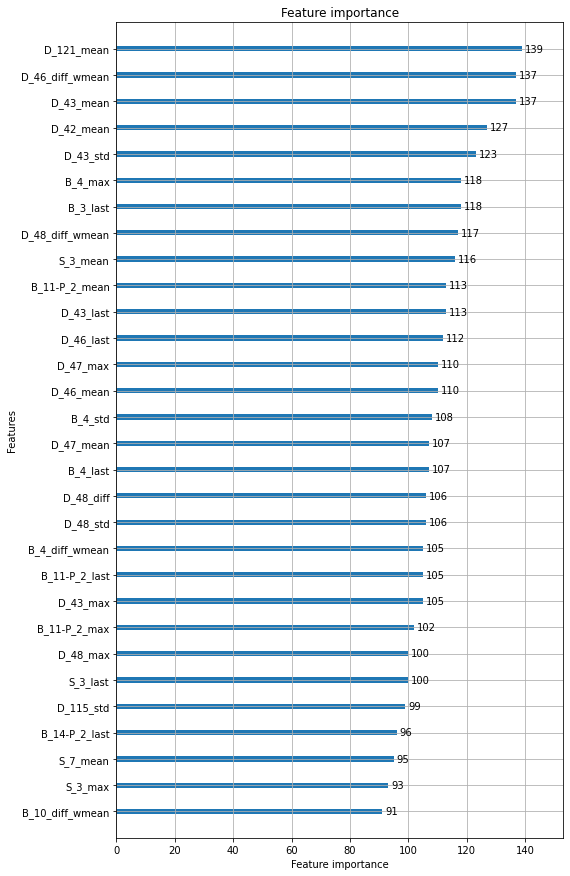

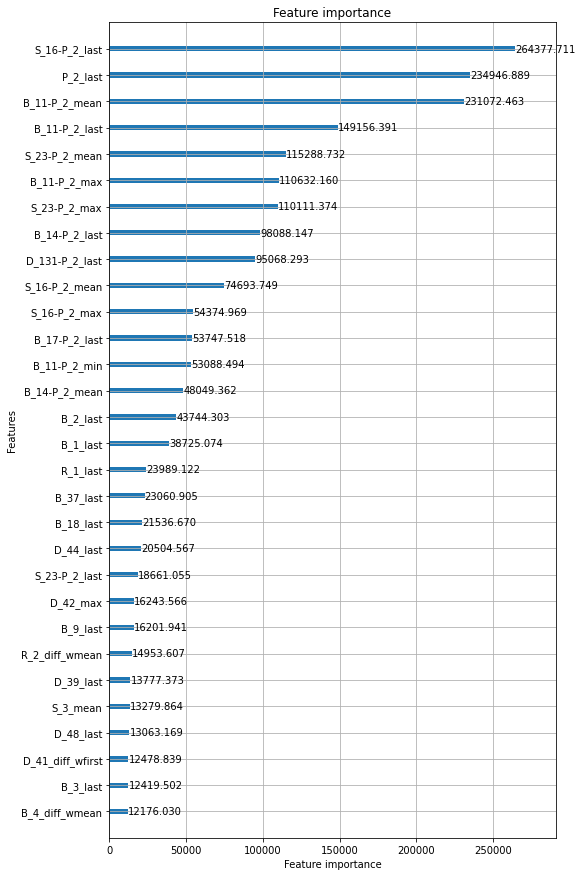

######################################## training model 2/5 ########################################


Training until validation scores don't improve for 300 rounds


[50]	valid_0's amex_metric: 0.761861	valid_0's recall_at4: 0.616006	valid_0's norm_gini: 0.907715


[100]	valid_0's amex_metric: 0.773386	valid_0's recall_at4: 0.632164	valid_0's norm_gini: 0.914609


[150]	valid_0's amex_metric: 0.780639	valid_0's recall_at4: 0.643104	valid_0's norm_gini: 0.918174


[200]	valid_0's amex_metric: 0.783413	valid_0's recall_at4: 0.646806	valid_0's norm_gini: 0.92002


[250]	valid_0's amex_metric: 0.786111	valid_0's recall_at4: 0.651014	valid_0's norm_gini: 0.921209


[300]	valid_0's amex_metric: 0.787592	valid_0's recall_at4: 0.653202	valid_0's norm_gini: 0.921982


[350]	valid_0's amex_metric: 0.788675	valid_0's recall_at4: 0.654843	valid_0's norm_gini: 0.922508


[400]	valid_0's amex_metric: 0.789217	valid_0's recall_at4: 0.6556	valid_0's norm_gini: 0.922834


[450]	valid_0's amex_metric: 0.790368	valid_0's recall_at4: 0.657662	valid_0's norm_gini: 0.923074


[500]	valid_0's amex_metric: 0.790565	valid_0's recall_at4: 0.657831	valid_0's norm_gini: 0.9233


[550]	valid_0's amex_metric: 0.790614	valid_0's recall_at4: 0.657746	valid_0's norm_gini: 0.923481


[600]	valid_0's amex_metric: 0.790443	valid_0's recall_at4: 0.657241	valid_0's norm_gini: 0.923644


[650]	valid_0's amex_metric: 0.790978	valid_0's recall_at4: 0.658125	valid_0's norm_gini: 0.923831


[700]	valid_0's amex_metric: 0.791499	valid_0's recall_at4: 0.659051	valid_0's norm_gini: 0.923948


[750]	valid_0's amex_metric: 0.791495	valid_0's recall_at4: 0.658925	valid_0's norm_gini: 0.924066


[800]	valid_0's amex_metric: 0.791586	valid_0's recall_at4: 0.659093	valid_0's norm_gini: 0.92408


[850]	valid_0's amex_metric: 0.792007	valid_0's recall_at4: 0.65985	valid_0's norm_gini: 0.924164


[900]	valid_0's amex_metric: 0.792159	valid_0's recall_at4: 0.660103	valid_0's norm_gini: 0.924216


[950]	valid_0's amex_metric: 0.792171	valid_0's recall_at4: 0.660061	valid_0's norm_gini: 0.924281


[1000]	valid_0's amex_metric: 0.79262	valid_0's recall_at4: 0.660902	valid_0's norm_gini: 0.924337


[1050]	valid_0's amex_metric: 0.792542	valid_0's recall_at4: 0.660692	valid_0's norm_gini: 0.924391


[1100]	valid_0's amex_metric: 0.792878	valid_0's recall_at4: 0.661365	valid_0's norm_gini: 0.92439


[1150]	valid_0's amex_metric: 0.793354	valid_0's recall_at4: 0.662291	valid_0's norm_gini: 0.924418


[1200]	valid_0's amex_metric: 0.793019	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.924421


[1250]	valid_0's amex_metric: 0.793176	valid_0's recall_at4: 0.661912	valid_0's norm_gini: 0.92444


[1300]	valid_0's amex_metric: 0.792454	valid_0's recall_at4: 0.660481	valid_0's norm_gini: 0.924427


[1350]	valid_0's amex_metric: 0.79303	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.924443


[1400]	valid_0's amex_metric: 0.792779	valid_0's recall_at4: 0.661112	valid_0's norm_gini: 0.924445


Early stopping, best iteration is:
[1131]	valid_0's amex_metric: 0.793415	valid_0's recall_at4: 0.662417	valid_0's norm_gini: 0.924413
Evaluated only: amex_metric


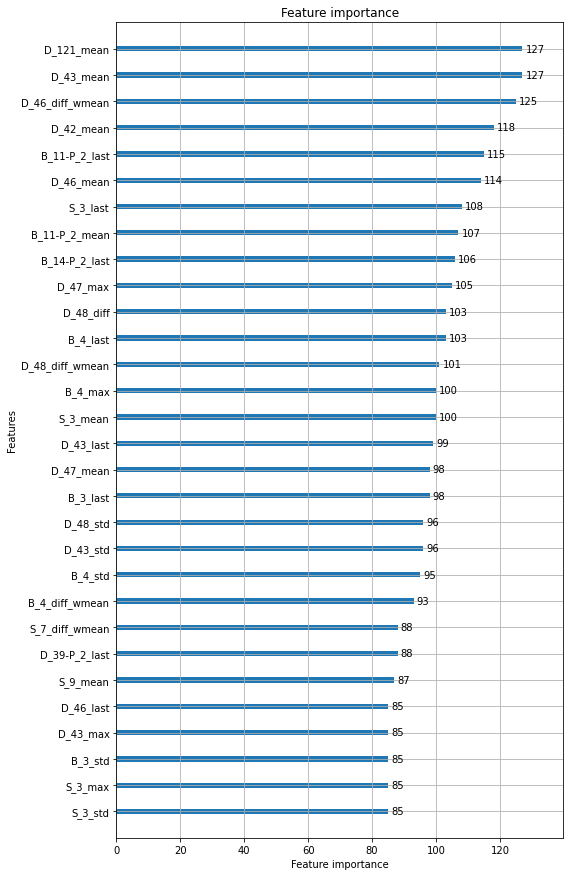

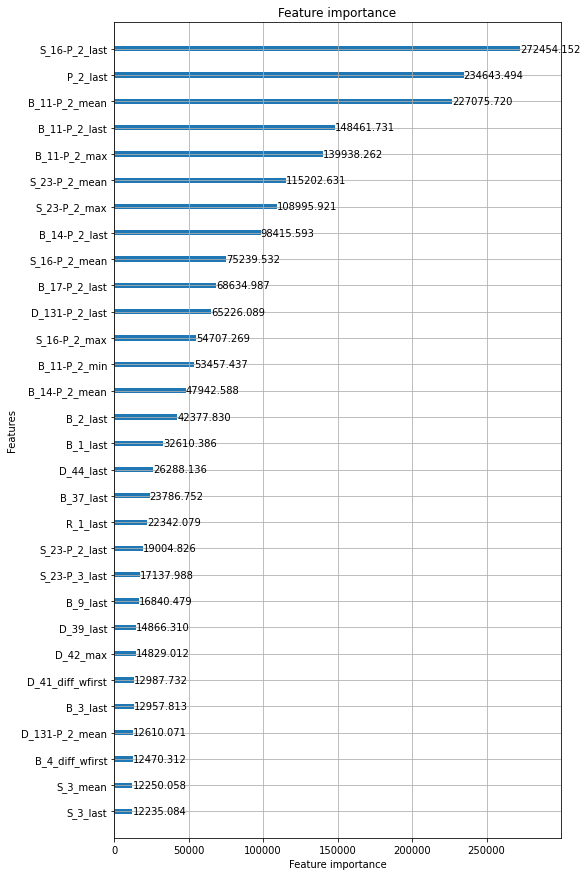

######################################## training model 3/5 ########################################


Training until validation scores don't improve for 300 rounds


[50]	valid_0's amex_metric: 0.756876	valid_0's recall_at4: 0.607843	valid_0's norm_gini: 0.905909


[100]	valid_0's amex_metric: 0.771129	valid_0's recall_at4: 0.628882	valid_0's norm_gini: 0.913376


[150]	valid_0's amex_metric: 0.778772	valid_0's recall_at4: 0.640369	valid_0's norm_gini: 0.917175


[200]	valid_0's amex_metric: 0.782656	valid_0's recall_at4: 0.646049	valid_0's norm_gini: 0.919262


[250]	valid_0's amex_metric: 0.784426	valid_0's recall_at4: 0.648405	valid_0's norm_gini: 0.920447


[300]	valid_0's amex_metric: 0.786497	valid_0's recall_at4: 0.651687	valid_0's norm_gini: 0.921307


[350]	valid_0's amex_metric: 0.787548	valid_0's recall_at4: 0.653202	valid_0's norm_gini: 0.921893


[400]	valid_0's amex_metric: 0.788059	valid_0's recall_at4: 0.653833	valid_0's norm_gini: 0.922285


[450]	valid_0's amex_metric: 0.788736	valid_0's recall_at4: 0.654885	valid_0's norm_gini: 0.922588


[500]	valid_0's amex_metric: 0.789585	valid_0's recall_at4: 0.656316	valid_0's norm_gini: 0.922854


[550]	valid_0's amex_metric: 0.789304	valid_0's recall_at4: 0.6556	valid_0's norm_gini: 0.923007


[600]	valid_0's amex_metric: 0.78939	valid_0's recall_at4: 0.6556	valid_0's norm_gini: 0.92318


[650]	valid_0's amex_metric: 0.789807	valid_0's recall_at4: 0.656316	valid_0's norm_gini: 0.923299


[700]	valid_0's amex_metric: 0.790004	valid_0's recall_at4: 0.65661	valid_0's norm_gini: 0.923397


[750]	valid_0's amex_metric: 0.790203	valid_0's recall_at4: 0.656905	valid_0's norm_gini: 0.923502


[800]	valid_0's amex_metric: 0.78972	valid_0's recall_at4: 0.655811	valid_0's norm_gini: 0.923628


[850]	valid_0's amex_metric: 0.79055	valid_0's recall_at4: 0.65741	valid_0's norm_gini: 0.923689


[900]	valid_0's amex_metric: 0.79029	valid_0's recall_at4: 0.656863	valid_0's norm_gini: 0.923718


[950]	valid_0's amex_metric: 0.790421	valid_0's recall_at4: 0.657073	valid_0's norm_gini: 0.923769


[1000]	valid_0's amex_metric: 0.790405	valid_0's recall_at4: 0.656989	valid_0's norm_gini: 0.92382


[1050]	valid_0's amex_metric: 0.790449	valid_0's recall_at4: 0.657073	valid_0's norm_gini: 0.923825


[1100]	valid_0's amex_metric: 0.791051	valid_0's recall_at4: 0.658251	valid_0's norm_gini: 0.92385


[1150]	valid_0's amex_metric: 0.791197	valid_0's recall_at4: 0.658546	valid_0's norm_gini: 0.923847


[1200]	valid_0's amex_metric: 0.790886	valid_0's recall_at4: 0.657915	valid_0's norm_gini: 0.923858


[1250]	valid_0's amex_metric: 0.791683	valid_0's recall_at4: 0.659514	valid_0's norm_gini: 0.923852


[1300]	valid_0's amex_metric: 0.792295	valid_0's recall_at4: 0.660692	valid_0's norm_gini: 0.923898


[1350]	valid_0's amex_metric: 0.791077	valid_0's recall_at4: 0.658251	valid_0's norm_gini: 0.923902


[1400]	valid_0's amex_metric: 0.79123	valid_0's recall_at4: 0.658546	valid_0's norm_gini: 0.923915


[1450]	valid_0's amex_metric: 0.791446	valid_0's recall_at4: 0.658967	valid_0's norm_gini: 0.923925


[1500]	valid_0's amex_metric: 0.791729	valid_0's recall_at4: 0.659556	valid_0's norm_gini: 0.923902


[1550]	valid_0's amex_metric: 0.791709	valid_0's recall_at4: 0.659514	valid_0's norm_gini: 0.923904


[1600]	valid_0's amex_metric: 0.791945	valid_0's recall_at4: 0.659976	valid_0's norm_gini: 0.923914
Early stopping, best iteration is:
[1301]	valid_0's amex_metric: 0.792652	valid_0's recall_at4: 0.661407	valid_0's norm_gini: 0.923897
Evaluated only: amex_metric


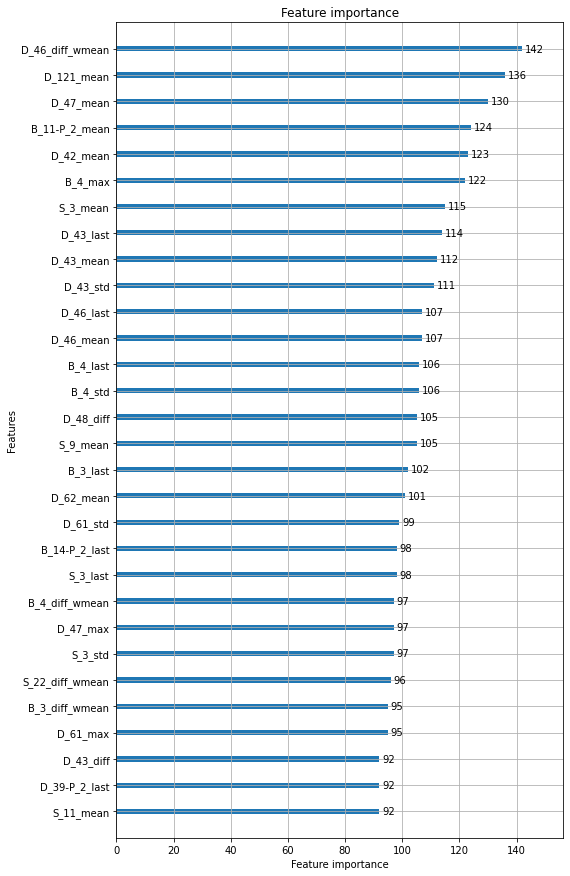

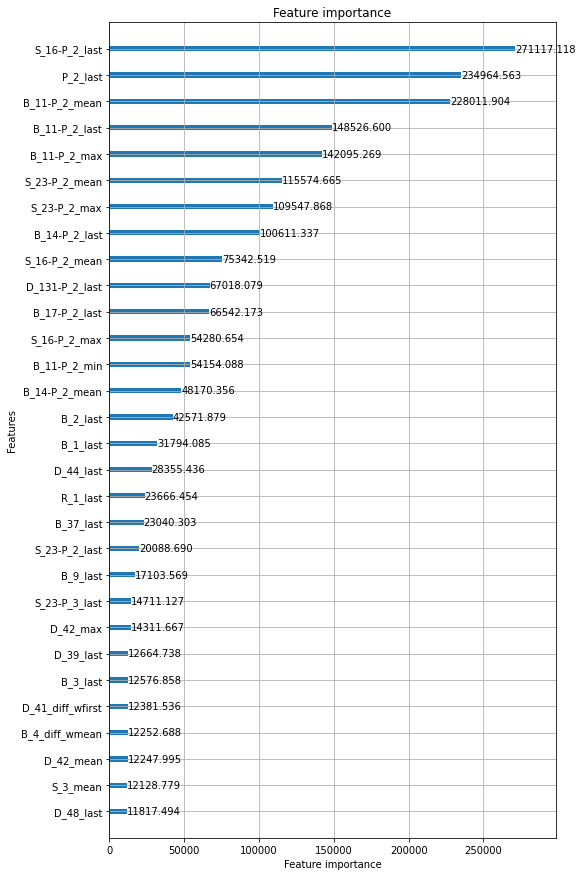

######################################## training model 4/5 ########################################


Training until validation scores don't improve for 300 rounds


[50]	valid_0's amex_metric: 0.765255	valid_0's recall_at4: 0.622175	valid_0's norm_gini: 0.908335


[100]	valid_0's amex_metric: 0.778577	valid_0's recall_at4: 0.641742	valid_0's norm_gini: 0.915411


[150]	valid_0's amex_metric: 0.78634	valid_0's recall_at4: 0.653777	valid_0's norm_gini: 0.918903


[200]	valid_0's amex_metric: 0.789215	valid_0's recall_at4: 0.657606	valid_0's norm_gini: 0.920824


[250]	valid_0's amex_metric: 0.791395	valid_0's recall_at4: 0.660804	valid_0's norm_gini: 0.921987


[300]	valid_0's amex_metric: 0.792501	valid_0's recall_at4: 0.662276	valid_0's norm_gini: 0.922725


[350]	valid_0's amex_metric: 0.793546	valid_0's recall_at4: 0.663833	valid_0's norm_gini: 0.923259


[400]	valid_0's amex_metric: 0.794623	valid_0's recall_at4: 0.665601	valid_0's norm_gini: 0.923646


[450]	valid_0's amex_metric: 0.794943	valid_0's recall_at4: 0.665937	valid_0's norm_gini: 0.92395


[500]	valid_0's amex_metric: 0.795682	valid_0's recall_at4: 0.667158	valid_0's norm_gini: 0.924205


[550]	valid_0's amex_metric: 0.79659	valid_0's recall_at4: 0.668757	valid_0's norm_gini: 0.924422


[600]	valid_0's amex_metric: 0.796386	valid_0's recall_at4: 0.668252	valid_0's norm_gini: 0.92452


[650]	valid_0's amex_metric: 0.79723	valid_0's recall_at4: 0.669809	valid_0's norm_gini: 0.924651


[700]	valid_0's amex_metric: 0.797146	valid_0's recall_at4: 0.669514	valid_0's norm_gini: 0.924777


[750]	valid_0's amex_metric: 0.796653	valid_0's recall_at4: 0.668462	valid_0's norm_gini: 0.924845


[800]	valid_0's amex_metric: 0.797721	valid_0's recall_at4: 0.670566	valid_0's norm_gini: 0.924877


[850]	valid_0's amex_metric: 0.797777	valid_0's recall_at4: 0.670608	valid_0's norm_gini: 0.924946


[900]	valid_0's amex_metric: 0.797608	valid_0's recall_at4: 0.670229	valid_0's norm_gini: 0.924988


[950]	valid_0's amex_metric: 0.797438	valid_0's recall_at4: 0.669809	valid_0's norm_gini: 0.925067


[1000]	valid_0's amex_metric: 0.797807	valid_0's recall_at4: 0.670482	valid_0's norm_gini: 0.925132


[1050]	valid_0's amex_metric: 0.797801	valid_0's recall_at4: 0.67044	valid_0's norm_gini: 0.925163


[1100]	valid_0's amex_metric: 0.798005	valid_0's recall_at4: 0.670818	valid_0's norm_gini: 0.925191


[1150]	valid_0's amex_metric: 0.797859	valid_0's recall_at4: 0.670482	valid_0's norm_gini: 0.925236


[1200]	valid_0's amex_metric: 0.797905	valid_0's recall_at4: 0.670566	valid_0's norm_gini: 0.925244


[1250]	valid_0's amex_metric: 0.797364	valid_0's recall_at4: 0.669472	valid_0's norm_gini: 0.925256


[1300]	valid_0's amex_metric: 0.798011	valid_0's recall_at4: 0.670734	valid_0's norm_gini: 0.925289


Early stopping, best iteration is:
[1005]	valid_0's amex_metric: 0.798251	valid_0's recall_at4: 0.671365	valid_0's norm_gini: 0.925137
Evaluated only: amex_metric


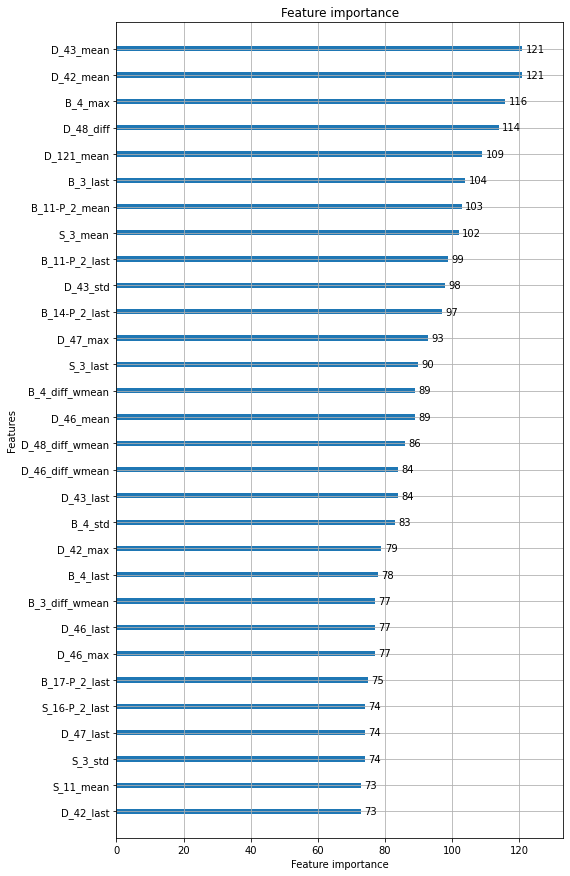

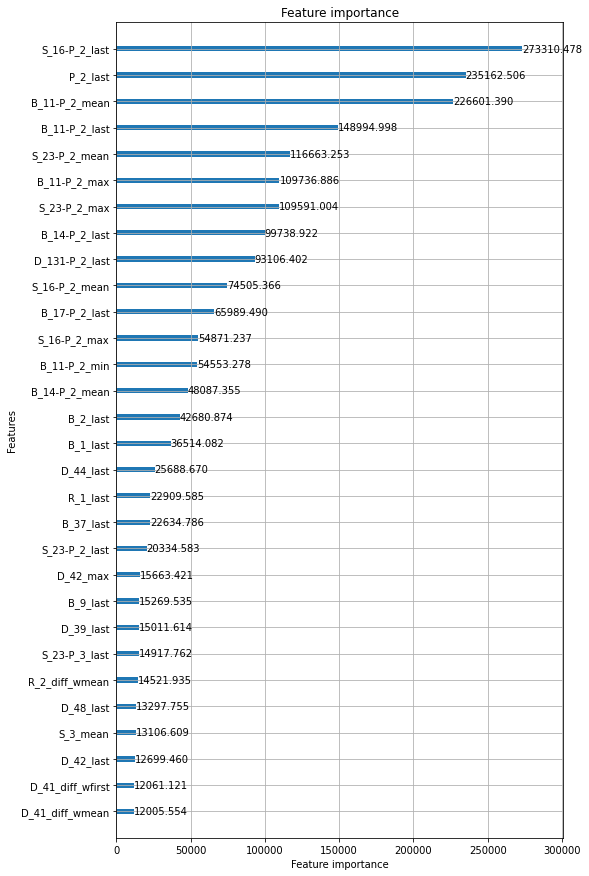

######################################## training model 5/5 ########################################


Training until validation scores don't improve for 300 rounds


[50]	valid_0's amex_metric: 0.765745	valid_0's recall_at4: 0.622975	valid_0's norm_gini: 0.908514


[100]	valid_0's amex_metric: 0.776717	valid_0's recall_at4: 0.638039	valid_0's norm_gini: 0.915396


[150]	valid_0's amex_metric: 0.783092	valid_0's recall_at4: 0.647296	valid_0's norm_gini: 0.918888


[200]	valid_0's amex_metric: 0.786827	valid_0's recall_at4: 0.652851	valid_0's norm_gini: 0.920804


[250]	valid_0's amex_metric: 0.789568	valid_0's recall_at4: 0.657227	valid_0's norm_gini: 0.92191


[300]	valid_0's amex_metric: 0.790823	valid_0's recall_at4: 0.658994	valid_0's norm_gini: 0.922651


[350]	valid_0's amex_metric: 0.79211	valid_0's recall_at4: 0.661056	valid_0's norm_gini: 0.923164


[400]	valid_0's amex_metric: 0.792464	valid_0's recall_at4: 0.661435	valid_0's norm_gini: 0.923493


[450]	valid_0's amex_metric: 0.792481	valid_0's recall_at4: 0.661182	valid_0's norm_gini: 0.92378


[500]	valid_0's amex_metric: 0.792998	valid_0's recall_at4: 0.661982	valid_0's norm_gini: 0.924014


[550]	valid_0's amex_metric: 0.793641	valid_0's recall_at4: 0.663118	valid_0's norm_gini: 0.924165


[600]	valid_0's amex_metric: 0.793436	valid_0's recall_at4: 0.662529	valid_0's norm_gini: 0.924342


[650]	valid_0's amex_metric: 0.793657	valid_0's recall_at4: 0.662866	valid_0's norm_gini: 0.924448


[700]	valid_0's amex_metric: 0.793261	valid_0's recall_at4: 0.661982	valid_0's norm_gini: 0.924539


[750]	valid_0's amex_metric: 0.793799	valid_0's recall_at4: 0.662992	valid_0's norm_gini: 0.924605


[800]	valid_0's amex_metric: 0.793966	valid_0's recall_at4: 0.663244	valid_0's norm_gini: 0.924688


[850]	valid_0's amex_metric: 0.793855	valid_0's recall_at4: 0.662908	valid_0's norm_gini: 0.924803


[900]	valid_0's amex_metric: 0.79451	valid_0's recall_at4: 0.66417	valid_0's norm_gini: 0.92485


[950]	valid_0's amex_metric: 0.794784	valid_0's recall_at4: 0.664675	valid_0's norm_gini: 0.924892


[1000]	valid_0's amex_metric: 0.794281	valid_0's recall_at4: 0.663623	valid_0's norm_gini: 0.924938


[1050]	valid_0's amex_metric: 0.794425	valid_0's recall_at4: 0.663875	valid_0's norm_gini: 0.924974


[1100]	valid_0's amex_metric: 0.79471	valid_0's recall_at4: 0.664422	valid_0's norm_gini: 0.924998


[1150]	valid_0's amex_metric: 0.795341	valid_0's recall_at4: 0.665643	valid_0's norm_gini: 0.92504


[1200]	valid_0's amex_metric: 0.795076	valid_0's recall_at4: 0.665138	valid_0's norm_gini: 0.925015


[1250]	valid_0's amex_metric: 0.794833	valid_0's recall_at4: 0.664633	valid_0's norm_gini: 0.925033


[1300]	valid_0's amex_metric: 0.795498	valid_0's recall_at4: 0.665979	valid_0's norm_gini: 0.925017


[1350]	valid_0's amex_metric: 0.79554	valid_0's recall_at4: 0.666064	valid_0's norm_gini: 0.925017


[1400]	valid_0's amex_metric: 0.795539	valid_0's recall_at4: 0.666021	valid_0's norm_gini: 0.925057


[1450]	valid_0's amex_metric: 0.795326	valid_0's recall_at4: 0.665559	valid_0's norm_gini: 0.925093


[1500]	valid_0's amex_metric: 0.79513	valid_0's recall_at4: 0.66518	valid_0's norm_gini: 0.92508


[1550]	valid_0's amex_metric: 0.795167	valid_0's recall_at4: 0.665264	valid_0's norm_gini: 0.92507


[1600]	valid_0's amex_metric: 0.795079	valid_0's recall_at4: 0.665054	valid_0's norm_gini: 0.925104


[1650]	valid_0's amex_metric: 0.794857	valid_0's recall_at4: 0.664591	valid_0's norm_gini: 0.925123


Early stopping, best iteration is:
[1387]	valid_0's amex_metric: 0.795765	valid_0's recall_at4: 0.666484	valid_0's norm_gini: 0.925047
Evaluated only: amex_metric


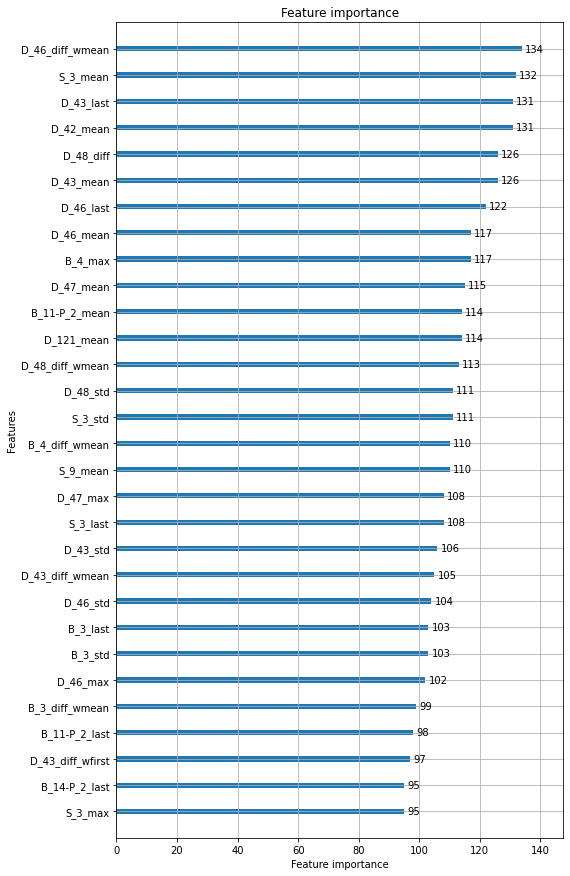

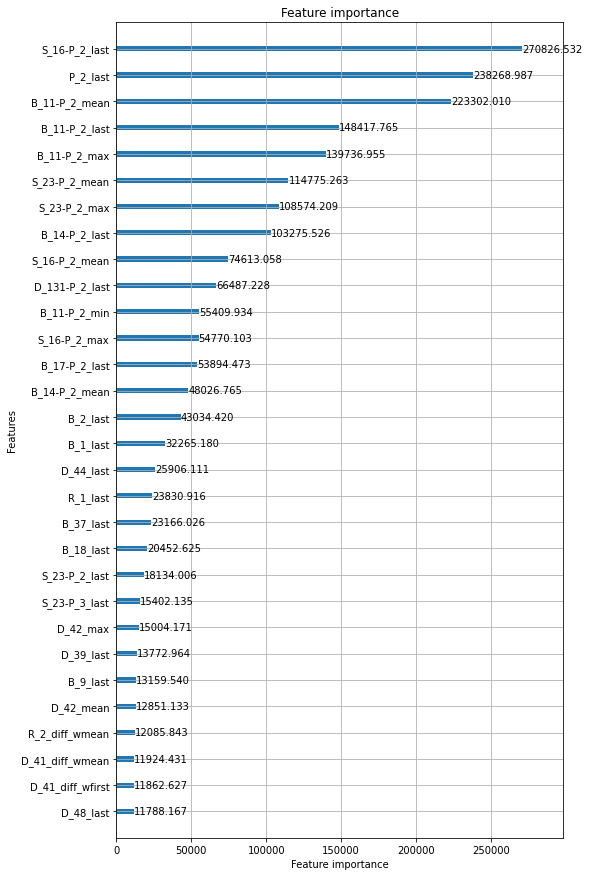

Training time: 17.77285977999369 min.
OOF recall_at4: 0.6654828828222304
OOF normalized_gini: 0.9246576808267669
OOF competition metric: 0.7950702818244987


############################### repeated cross-validation step: 3/3 ################################


######################################## training model 1/5 ########################################


Training until validation scores don't improve for 300 rounds


[50]	valid_0's amex_metric: 0.759966	valid_0's recall_at4: 0.613481	valid_0's norm_gini: 0.90645


[100]	valid_0's amex_metric: 0.772791	valid_0's recall_at4: 0.631953	valid_0's norm_gini: 0.913628


[150]	valid_0's amex_metric: 0.780205	valid_0's recall_at4: 0.643104	valid_0's norm_gini: 0.917307


[200]	valid_0's amex_metric: 0.784514	valid_0's recall_at4: 0.649836	valid_0's norm_gini: 0.919192


[250]	valid_0's amex_metric: 0.786854	valid_0's recall_at4: 0.653328	valid_0's norm_gini: 0.920379


[300]	valid_0's amex_metric: 0.787919	valid_0's recall_at4: 0.654675	valid_0's norm_gini: 0.921163


[350]	valid_0's amex_metric: 0.789166	valid_0's recall_at4: 0.65661	valid_0's norm_gini: 0.921722


[400]	valid_0's amex_metric: 0.789328	valid_0's recall_at4: 0.656568	valid_0's norm_gini: 0.922089


[450]	valid_0's amex_metric: 0.790095	valid_0's recall_at4: 0.657831	valid_0's norm_gini: 0.922359


[500]	valid_0's amex_metric: 0.790838	valid_0's recall_at4: 0.659093	valid_0's norm_gini: 0.922584


[550]	valid_0's amex_metric: 0.791729	valid_0's recall_at4: 0.660692	valid_0's norm_gini: 0.922766


[600]	valid_0's amex_metric: 0.792523	valid_0's recall_at4: 0.662122	valid_0's norm_gini: 0.922925


[650]	valid_0's amex_metric: 0.792325	valid_0's recall_at4: 0.661575	valid_0's norm_gini: 0.923076


[700]	valid_0's amex_metric: 0.79254	valid_0's recall_at4: 0.661912	valid_0's norm_gini: 0.923168


[750]	valid_0's amex_metric: 0.792797	valid_0's recall_at4: 0.662375	valid_0's norm_gini: 0.92322


[800]	valid_0's amex_metric: 0.793187	valid_0's recall_at4: 0.66309	valid_0's norm_gini: 0.923284


[850]	valid_0's amex_metric: 0.792785	valid_0's recall_at4: 0.662207	valid_0's norm_gini: 0.923364


[900]	valid_0's amex_metric: 0.792875	valid_0's recall_at4: 0.662333	valid_0's norm_gini: 0.923417


[950]	valid_0's amex_metric: 0.793212	valid_0's recall_at4: 0.663006	valid_0's norm_gini: 0.923417


[1000]	valid_0's amex_metric: 0.793326	valid_0's recall_at4: 0.663216	valid_0's norm_gini: 0.923436


[1050]	valid_0's amex_metric: 0.793368	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.923436


[1100]	valid_0's amex_metric: 0.793702	valid_0's recall_at4: 0.663932	valid_0's norm_gini: 0.923473


[1150]	valid_0's amex_metric: 0.793109	valid_0's recall_at4: 0.662711	valid_0's norm_gini: 0.923506


[1200]	valid_0's amex_metric: 0.793173	valid_0's recall_at4: 0.662838	valid_0's norm_gini: 0.923509


[1250]	valid_0's amex_metric: 0.793459	valid_0's recall_at4: 0.663385	valid_0's norm_gini: 0.923534


[1300]	valid_0's amex_metric: 0.79272	valid_0's recall_at4: 0.661912	valid_0's norm_gini: 0.923527


[1350]	valid_0's amex_metric: 0.792995	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.92353


Early stopping, best iteration is:
[1099]	valid_0's amex_metric: 0.793932	valid_0's recall_at4: 0.664394	valid_0's norm_gini: 0.92347
Evaluated only: amex_metric


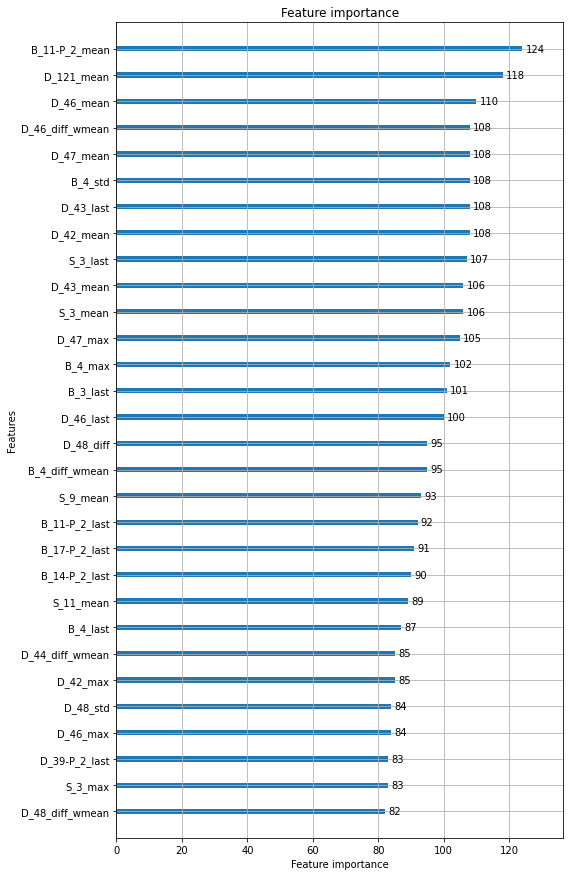

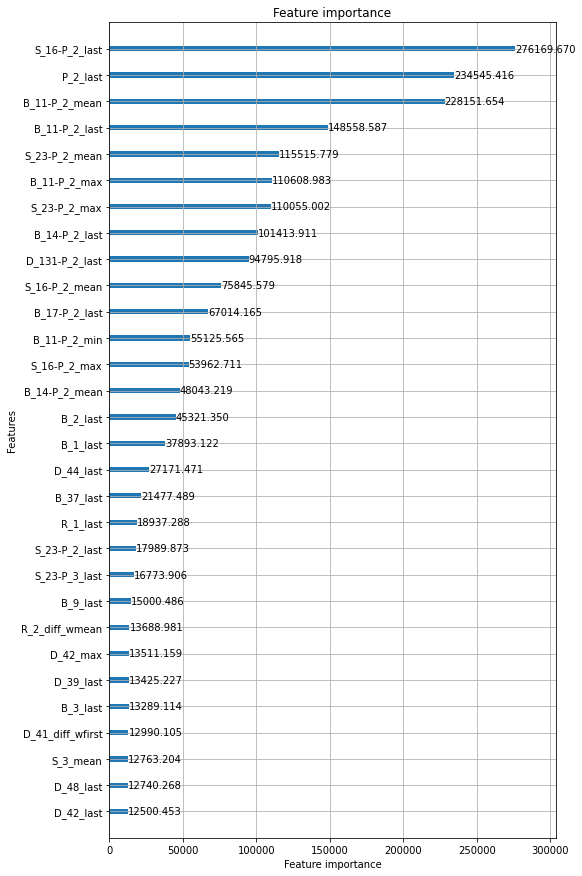

######################################## training model 2/5 ########################################


Training until validation scores don't improve for 300 rounds


[50]	valid_0's amex_metric: 0.760809	valid_0's recall_at4: 0.61365	valid_0's norm_gini: 0.907968


[100]	valid_0's amex_metric: 0.773346	valid_0's recall_at4: 0.631953	valid_0's norm_gini: 0.914739


[150]	valid_0's amex_metric: 0.778438	valid_0's recall_at4: 0.638601	valid_0's norm_gini: 0.918276


[200]	valid_0's amex_metric: 0.781981	valid_0's recall_at4: 0.643693	valid_0's norm_gini: 0.920269


[250]	valid_0's amex_metric: 0.784105	valid_0's recall_at4: 0.646848	valid_0's norm_gini: 0.921361


[300]	valid_0's amex_metric: 0.786081	valid_0's recall_at4: 0.649962	valid_0's norm_gini: 0.922199


[350]	valid_0's amex_metric: 0.787533	valid_0's recall_at4: 0.652318	valid_0's norm_gini: 0.922747


[400]	valid_0's amex_metric: 0.788786	valid_0's recall_at4: 0.65438	valid_0's norm_gini: 0.923192


[450]	valid_0's amex_metric: 0.788205	valid_0's recall_at4: 0.652907	valid_0's norm_gini: 0.923502


[500]	valid_0's amex_metric: 0.788662	valid_0's recall_at4: 0.653581	valid_0's norm_gini: 0.923743


[550]	valid_0's amex_metric: 0.788998	valid_0's recall_at4: 0.654044	valid_0's norm_gini: 0.923953


[600]	valid_0's amex_metric: 0.788954	valid_0's recall_at4: 0.653791	valid_0's norm_gini: 0.924116


[650]	valid_0's amex_metric: 0.789244	valid_0's recall_at4: 0.654212	valid_0's norm_gini: 0.924275


[700]	valid_0's amex_metric: 0.789083	valid_0's recall_at4: 0.653791	valid_0's norm_gini: 0.924376


[750]	valid_0's amex_metric: 0.789093	valid_0's recall_at4: 0.653707	valid_0's norm_gini: 0.92448


[800]	valid_0's amex_metric: 0.789225	valid_0's recall_at4: 0.653875	valid_0's norm_gini: 0.924574


[850]	valid_0's amex_metric: 0.789504	valid_0's recall_at4: 0.65438	valid_0's norm_gini: 0.924629


[900]	valid_0's amex_metric: 0.788924	valid_0's recall_at4: 0.65316	valid_0's norm_gini: 0.924688


Early stopping, best iteration is:
[631]	valid_0's amex_metric: 0.789849	valid_0's recall_at4: 0.655474	valid_0's norm_gini: 0.924223
Evaluated only: amex_metric


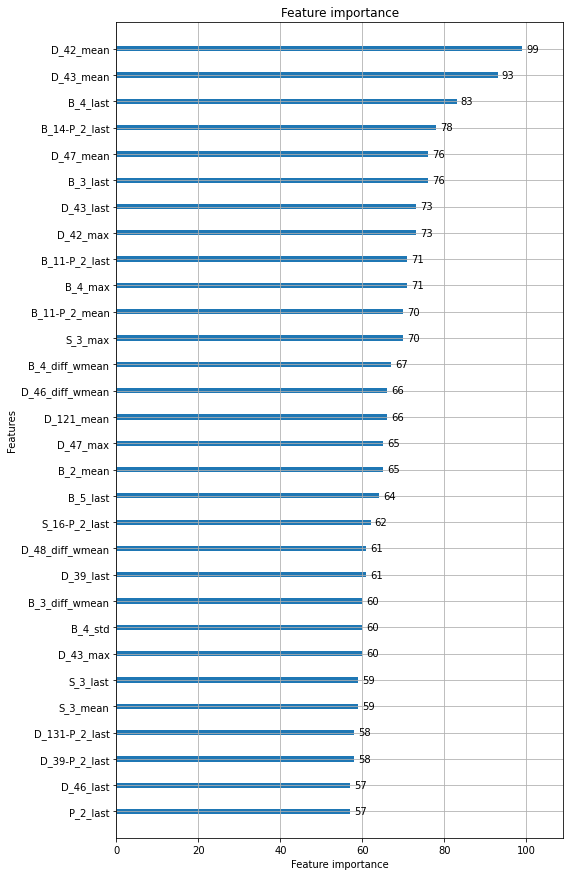

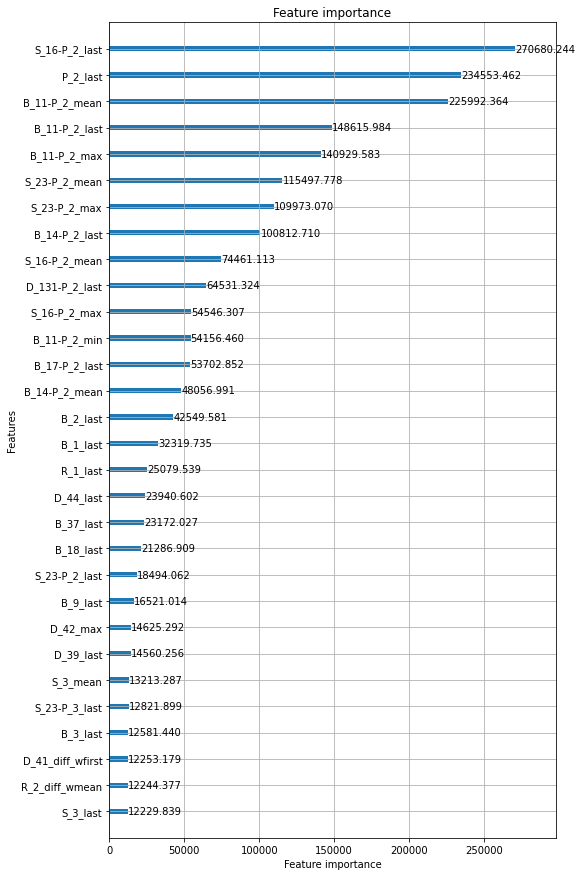

######################################## training model 3/5 ########################################


Training until validation scores don't improve for 300 rounds


[50]	valid_0's amex_metric: 0.765008	valid_0's recall_at4: 0.622991	valid_0's norm_gini: 0.907025


[100]	valid_0's amex_metric: 0.777266	valid_0's recall_at4: 0.640032	valid_0's norm_gini: 0.9145


[150]	valid_0's amex_metric: 0.784778	valid_0's recall_at4: 0.65114	valid_0's norm_gini: 0.918416


[200]	valid_0's amex_metric: 0.787598	valid_0's recall_at4: 0.654717	valid_0's norm_gini: 0.920479


[250]	valid_0's amex_metric: 0.790681	valid_0's recall_at4: 0.659682	valid_0's norm_gini: 0.92168


[300]	valid_0's amex_metric: 0.79323	valid_0's recall_at4: 0.664016	valid_0's norm_gini: 0.922445


[350]	valid_0's amex_metric: 0.794176	valid_0's recall_at4: 0.66532	valid_0's norm_gini: 0.923031


[400]	valid_0's amex_metric: 0.795073	valid_0's recall_at4: 0.666667	valid_0's norm_gini: 0.923479


[450]	valid_0's amex_metric: 0.795829	valid_0's recall_at4: 0.667887	valid_0's norm_gini: 0.923772


[500]	valid_0's amex_metric: 0.796543	valid_0's recall_at4: 0.669065	valid_0's norm_gini: 0.924022


[550]	valid_0's amex_metric: 0.796985	valid_0's recall_at4: 0.669738	valid_0's norm_gini: 0.924232


[600]	valid_0's amex_metric: 0.797293	valid_0's recall_at4: 0.670201	valid_0's norm_gini: 0.924384


[650]	valid_0's amex_metric: 0.797024	valid_0's recall_at4: 0.669528	valid_0's norm_gini: 0.92452


[700]	valid_0's amex_metric: 0.797511	valid_0's recall_at4: 0.670412	valid_0's norm_gini: 0.924611


[750]	valid_0's amex_metric: 0.797536	valid_0's recall_at4: 0.670369	valid_0's norm_gini: 0.924702


[800]	valid_0's amex_metric: 0.798135	valid_0's recall_at4: 0.671506	valid_0's norm_gini: 0.924765


[850]	valid_0's amex_metric: 0.798756	valid_0's recall_at4: 0.672726	valid_0's norm_gini: 0.924785


[900]	valid_0's amex_metric: 0.79786	valid_0's recall_at4: 0.670916	valid_0's norm_gini: 0.924804


[950]	valid_0's amex_metric: 0.79783	valid_0's recall_at4: 0.670832	valid_0's norm_gini: 0.924828


[1000]	valid_0's amex_metric: 0.796922	valid_0's recall_at4: 0.668981	valid_0's norm_gini: 0.924863


[1050]	valid_0's amex_metric: 0.797358	valid_0's recall_at4: 0.669822	valid_0's norm_gini: 0.924894


[1100]	valid_0's amex_metric: 0.797605	valid_0's recall_at4: 0.670285	valid_0's norm_gini: 0.924925


[1150]	valid_0's amex_metric: 0.797794	valid_0's recall_at4: 0.670622	valid_0's norm_gini: 0.924966


Early stopping, best iteration is:
[854]	valid_0's amex_metric: 0.79878	valid_0's recall_at4: 0.672768	valid_0's norm_gini: 0.924791
Evaluated only: amex_metric


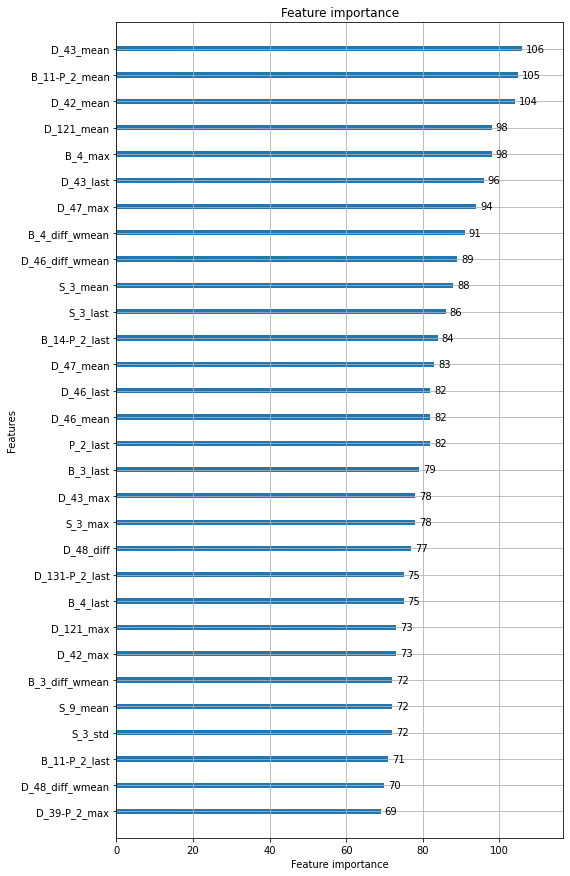

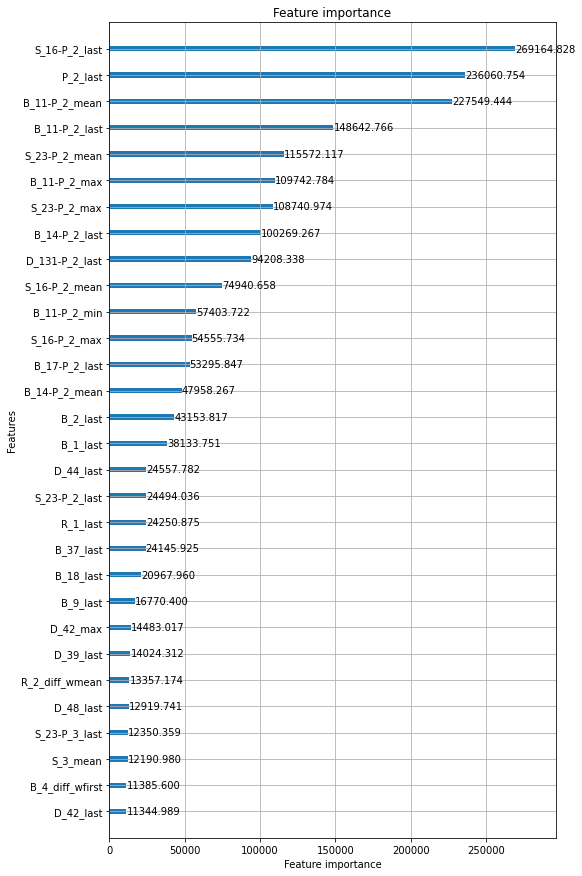

######################################## training model 4/5 ########################################


Training until validation scores don't improve for 300 rounds


[50]	valid_0's amex_metric: 0.768137	valid_0's recall_at4: 0.625373	valid_0's norm_gini: 0.9109


[100]	valid_0's amex_metric: 0.780854	valid_0's recall_at4: 0.643888	valid_0's norm_gini: 0.91782


[150]	valid_0's amex_metric: 0.789184	valid_0's recall_at4: 0.65689	valid_0's norm_gini: 0.921478


[200]	valid_0's amex_metric: 0.792843	valid_0's recall_at4: 0.662361	valid_0's norm_gini: 0.923326


[250]	valid_0's amex_metric: 0.794567	valid_0's recall_at4: 0.664675	valid_0's norm_gini: 0.924459


[300]	valid_0's amex_metric: 0.796448	valid_0's recall_at4: 0.667663	valid_0's norm_gini: 0.925233


[350]	valid_0's amex_metric: 0.79774	valid_0's recall_at4: 0.669724	valid_0's norm_gini: 0.925756


[400]	valid_0's amex_metric: 0.798498	valid_0's recall_at4: 0.670861	valid_0's norm_gini: 0.926136


[450]	valid_0's amex_metric: 0.79934	valid_0's recall_at4: 0.672249	valid_0's norm_gini: 0.926431


[500]	valid_0's amex_metric: 0.799863	valid_0's recall_at4: 0.673049	valid_0's norm_gini: 0.926678


[550]	valid_0's amex_metric: 0.800135	valid_0's recall_at4: 0.673427	valid_0's norm_gini: 0.926843


[600]	valid_0's amex_metric: 0.800117	valid_0's recall_at4: 0.673217	valid_0's norm_gini: 0.927018


[650]	valid_0's amex_metric: 0.800803	valid_0's recall_at4: 0.674479	valid_0's norm_gini: 0.927127


[700]	valid_0's amex_metric: 0.80059	valid_0's recall_at4: 0.673932	valid_0's norm_gini: 0.927248


[750]	valid_0's amex_metric: 0.801172	valid_0's recall_at4: 0.674984	valid_0's norm_gini: 0.92736


[800]	valid_0's amex_metric: 0.800955	valid_0's recall_at4: 0.674479	valid_0's norm_gini: 0.927431


[850]	valid_0's amex_metric: 0.801158	valid_0's recall_at4: 0.674816	valid_0's norm_gini: 0.9275


[900]	valid_0's amex_metric: 0.80089	valid_0's recall_at4: 0.674227	valid_0's norm_gini: 0.927553


[950]	valid_0's amex_metric: 0.801345	valid_0's recall_at4: 0.67511	valid_0's norm_gini: 0.927579


[1000]	valid_0's amex_metric: 0.801365	valid_0's recall_at4: 0.67511	valid_0's norm_gini: 0.92762


[1050]	valid_0's amex_metric: 0.801335	valid_0's recall_at4: 0.674984	valid_0's norm_gini: 0.927686


[1100]	valid_0's amex_metric: 0.80149	valid_0's recall_at4: 0.675279	valid_0's norm_gini: 0.927701


[1150]	valid_0's amex_metric: 0.80158	valid_0's recall_at4: 0.675447	valid_0's norm_gini: 0.927713


[1200]	valid_0's amex_metric: 0.801055	valid_0's recall_at4: 0.674395	valid_0's norm_gini: 0.927715


[1250]	valid_0's amex_metric: 0.801298	valid_0's recall_at4: 0.6749	valid_0's norm_gini: 0.927695


[1300]	valid_0's amex_metric: 0.801455	valid_0's recall_at4: 0.675195	valid_0's norm_gini: 0.927715


[1350]	valid_0's amex_metric: 0.801222	valid_0's recall_at4: 0.674732	valid_0's norm_gini: 0.927712


[1400]	valid_0's amex_metric: 0.801244	valid_0's recall_at4: 0.674774	valid_0's norm_gini: 0.927715


Early stopping, best iteration is:
[1115]	valid_0's amex_metric: 0.801918	valid_0's recall_at4: 0.67612	valid_0's norm_gini: 0.927716
Evaluated only: amex_metric


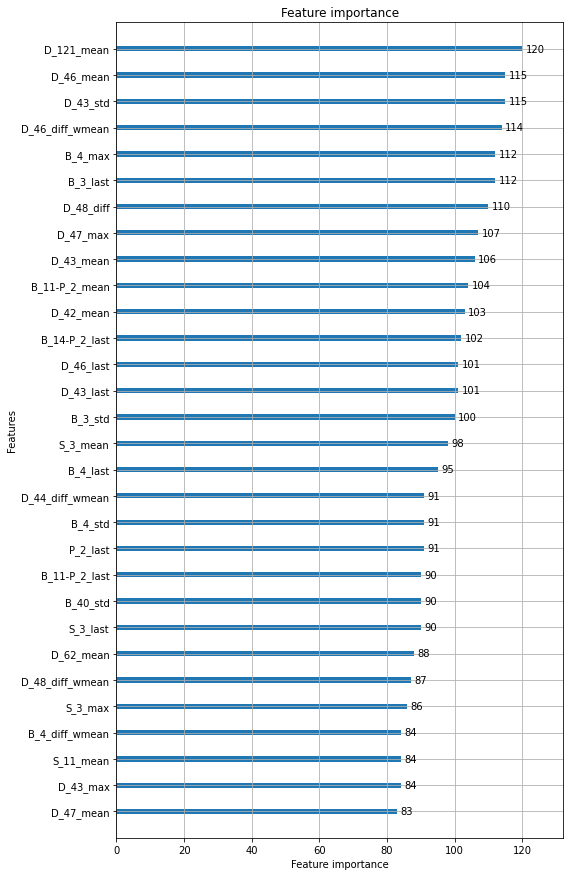

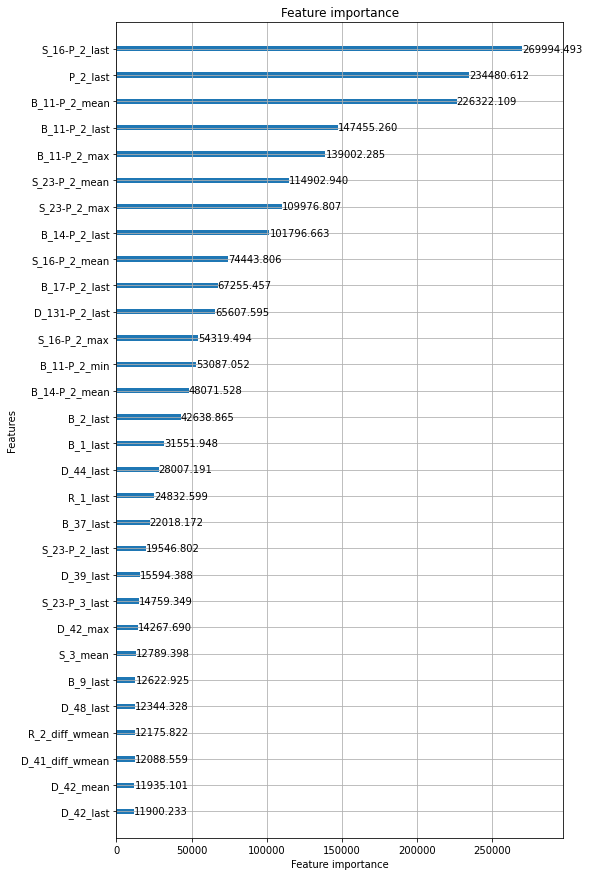

######################################## training model 5/5 ########################################


Training until validation scores don't improve for 300 rounds


[50]	valid_0's amex_metric: 0.765049	valid_0's recall_at4: 0.622849	valid_0's norm_gini: 0.907249


[100]	valid_0's amex_metric: 0.777451	valid_0's recall_at4: 0.640648	valid_0's norm_gini: 0.914255


[150]	valid_0's amex_metric: 0.782772	valid_0's recall_at4: 0.647759	valid_0's norm_gini: 0.917785


[200]	valid_0's amex_metric: 0.78636	valid_0's recall_at4: 0.653103	valid_0's norm_gini: 0.919616


[250]	valid_0's amex_metric: 0.788521	valid_0's recall_at4: 0.656301	valid_0's norm_gini: 0.920742


[300]	valid_0's amex_metric: 0.789896	valid_0's recall_at4: 0.658279	valid_0's norm_gini: 0.921512


[350]	valid_0's amex_metric: 0.791008	valid_0's recall_at4: 0.660004	valid_0's norm_gini: 0.922012


[400]	valid_0's amex_metric: 0.790987	valid_0's recall_at4: 0.659583	valid_0's norm_gini: 0.922391


[450]	valid_0's amex_metric: 0.792014	valid_0's recall_at4: 0.661309	valid_0's norm_gini: 0.922719


[500]	valid_0's amex_metric: 0.792094	valid_0's recall_at4: 0.661224	valid_0's norm_gini: 0.922963


[550]	valid_0's amex_metric: 0.792608	valid_0's recall_at4: 0.662066	valid_0's norm_gini: 0.923151


[600]	valid_0's amex_metric: 0.793286	valid_0's recall_at4: 0.663244	valid_0's norm_gini: 0.923327


[650]	valid_0's amex_metric: 0.793601	valid_0's recall_at4: 0.663749	valid_0's norm_gini: 0.923453


[700]	valid_0's amex_metric: 0.793167	valid_0's recall_at4: 0.662823	valid_0's norm_gini: 0.92351


[750]	valid_0's amex_metric: 0.793547	valid_0's recall_at4: 0.663497	valid_0's norm_gini: 0.923598


[800]	valid_0's amex_metric: 0.794382	valid_0's recall_at4: 0.665096	valid_0's norm_gini: 0.923669


[850]	valid_0's amex_metric: 0.794182	valid_0's recall_at4: 0.664633	valid_0's norm_gini: 0.923732


[900]	valid_0's amex_metric: 0.794383	valid_0's recall_at4: 0.66497	valid_0's norm_gini: 0.923796


[950]	valid_0's amex_metric: 0.794387	valid_0's recall_at4: 0.664927	valid_0's norm_gini: 0.923847


[1000]	valid_0's amex_metric: 0.794025	valid_0's recall_at4: 0.66417	valid_0's norm_gini: 0.92388


[1050]	valid_0's amex_metric: 0.794034	valid_0's recall_at4: 0.66417	valid_0's norm_gini: 0.923899


[1100]	valid_0's amex_metric: 0.794016	valid_0's recall_at4: 0.664086	valid_0's norm_gini: 0.923946


[1150]	valid_0's amex_metric: 0.793965	valid_0's recall_at4: 0.664002	valid_0's norm_gini: 0.923929


[1200]	valid_0's amex_metric: 0.793773	valid_0's recall_at4: 0.663623	valid_0's norm_gini: 0.923924


[1250]	valid_0's amex_metric: 0.793826	valid_0's recall_at4: 0.663707	valid_0's norm_gini: 0.923946


Early stopping, best iteration is:
[964]	valid_0's amex_metric: 0.794909	valid_0's recall_at4: 0.665937	valid_0's norm_gini: 0.923881
Evaluated only: amex_metric


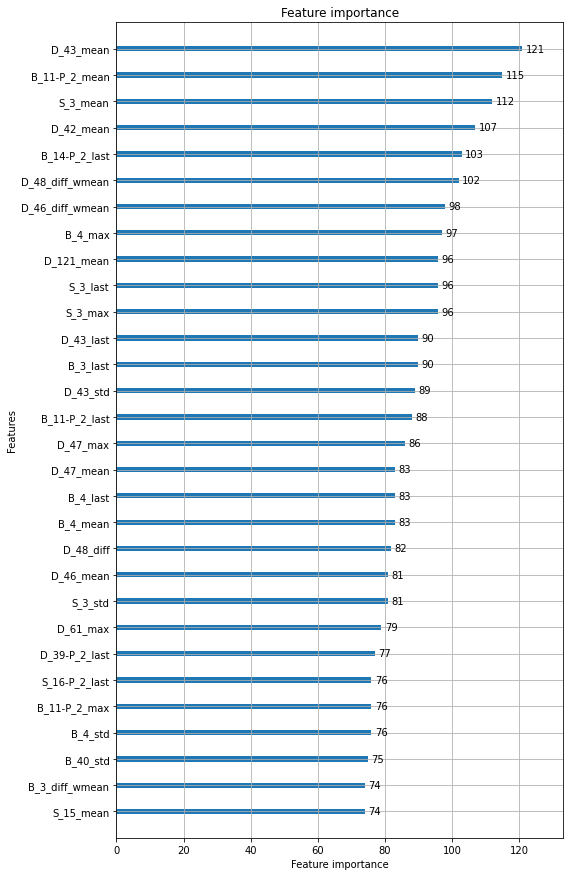

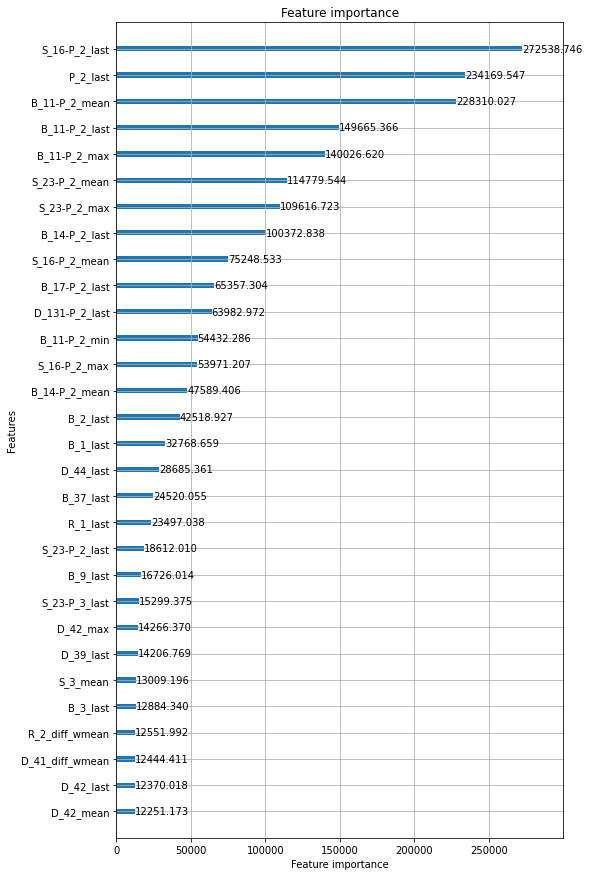

Training time: 14.963345960776012 min.
OOF recall_at4: 0.6660130608947387
OOF normalized_gini: 0.9246857254609859
OOF competition metric: 0.7953493931778624


CPU times: user 8h 52min 3s, sys: 1min 7s, total: 8h 53min 10s
Wall time: 47min 13s


In [11]:
%%time 

all_models = list()
all_oof_dfs = list()

for repetition in range(N_REPEATS):
    print(f" repeated cross-validation step: {repetition+1}/{N_REPEATS} ".center(100, "#"))

    folds = pd.read_csv(f'../data/processed/cv{repetition}.csv', index_col="customer_ID")
    _train = pd.merge(train, folds, how="inner", left_index=True, right_index=True).reset_index(drop=True)
    
    tic = time.time()
    models,oof = train_models(_train)
    tac = time.time()
    print(f"Training time: {(tac-tic)/60} min.")
          
    # oof metrics
    print("OOF recall_at4:", compute_recall_at4(oof.target.values, oof.pred.values))
    print("OOF normalized_gini:", compute_normalized_gini(oof.target.values, oof.pred.values))
    print("OOF competition metric:", compute_amex_metric(oof.target.values, oof.pred.values))
    
    all_models.append(models)
    all_oof_dfs.append(oof)
    
    # save oof predictions
    oof.to_csv(OOF_PATH/f"oof-cv{repetition}.csv", index=False)
    # save models
    for fold,_model in enumerate(models):
        _model.save_model(ART_PATH/f"/model-cv{repetition}-fold{fold}.txt")
          
    del _train, folds; gc.collect()

In [12]:
results = list()

for oof in all_oof_dfs:  
    r = {
        "recall_at4": compute_recall_at4(oof.target.values, oof.pred.values),
        "gini": compute_normalized_gini(oof.target.values, oof.pred.values),
        "metric": compute_amex_metric(oof.target.values, oof.pred.values),
    }
    results.append(r)

results = pd.DataFrame(results)
display(results)

print("\nmean:")
display(results.mean(axis=0))

print("\nstd:")
display(results.std(axis=0))

,recall_at4,gini,metric
0,0.664818,0.924489,0.794654
1,0.665483,0.924658,0.795070
2,0.666013,0.924686,0.795349



mean:


recall_at4    0.665438
gini          0.924611
metric        0.795024
dtype: float64


std:


recall_at4    0.000599
gini          0.000106
metric        0.000350
dtype: float64

In [13]:
del train
gc.collect()

21

***
## make predictions and submit

In [14]:
def make_predictions(dataframe:pd.DataFrame, input_feats:list, models:list) -> np.array:
    preds = [model.predict(dataframe[input_feats]) for model in models]
    return np.mean(preds, axis=0)    

In [15]:
test = pd.read_parquet(f"../data/processed/dsv{DATASET_VERSION}/test.parquet")
sub = pd.read_csv("../data/raw/sample_submission.csv")

In [16]:
%%time

all_preds = list()

for repetition in range(N_REPEATS):
    if "prediction" in sub.columns:
        sub.drop("prediction", axis=1, inplace=True)
    if "prediction" in test.columns:
        test.drop("prediction", axis=1, inplace=True)
        
    models = all_models[repetition]
    preds = make_predictions(test, input_feats, models)
    all_preds.append(preds)
       
    test["prediction"] = preds
    sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
    assert sub.prediction.isna().sum() == 0
    sub.to_csv(SUB_PATH/f"submission-cv{repetition}.csv", index=False)

CPU times: user 48min, sys: 56.1 s, total: 48min 56s
Wall time: 5min 38s


In [17]:
%%time
# predict using all the trained models
if "prediction" in sub.columns:
    sub.drop("prediction", axis=1, inplace=True)
if "prediction" in test.columns:
    test.drop("prediction", axis=1, inplace=True)

test["prediction"] = np.mean(all_preds, axis=0)
sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
assert sub.prediction.isna().sum() == 0
sub.to_csv(SUB_PATH/f"submission-all.csv", index=False)

CPU times: user 3.61 s, sys: 836 ms, total: 4.45 s
Wall time: 4.45 s


***